In [32]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. Load your dataset
df = pd.read_csv("CesDataClean4_subset.csv")  # or .csv if needed

# 2. Define continuous variables to standardize
continuous_vars = ['egrea_imean_bt', 
                   'egrea_istd_bt', 'lhhnetinc', 'age']

# 3. Initialize the scaler
scaler = StandardScaler()

# 4. Fit and transform, **overwrite the original columns**
df[continuous_vars] = scaler.fit_transform(df[continuous_vars])

# 5. Verify results (means ≈ 0, std ≈ 1)
print(df[continuous_vars].describe())

# 6. Save to a new CSV file
df.to_csv("CesDataClean4_subset_standardized4.csv", index=False)


       egrea_imean_bt  egrea_istd_bt     lhhnetinc           age
count    3.309000e+03   3.309000e+03  3.309000e+03  3.309000e+03
mean    -1.717843e-17   1.288382e-17 -4.294607e-16 -1.030706e-16
std      1.000151e+00   1.000151e+00  1.000151e+00  1.000151e+00
min     -5.485777e+00  -9.140124e-01 -8.077426e+00 -2.194926e+00
25%     -5.084618e-01  -6.095972e-01 -2.337684e-01 -7.958850e-01
50%      5.078703e-02  -3.051819e-01  2.123378e-01 -5.954785e-02
75%      4.981861e-01   3.036486e-01  5.824920e-01  7.504231e-01
max      4.972177e+00   9.131691e+00  3.027304e+00  3.180336e+00


In [18]:
import pandas as pd

# Load your dataset
df = pd.read_csv("CesDataClean4_subset_standardized4.csv")   # or pd.read_csv("CesDataClean3_subset.csv")

# Print all column names
print(df.columns.tolist())


['cons_tot_wave10', 'cons_tot_wave13', 'treat1', 'treat2', 'treat3', 'treat4', 'treat5', 'egrea_imean_bt', 'egrea_istd_bt', 'lhhnetinc', 'cnt1', 'cnt2', 'cnt3', 'cnt4', 'cnt5', 'cnt6', 'hhsize', 'male', 'dedu2', 'dedu3', 'age', 'liquid_wave9', 'sh_sav_wave9', 'sh_stock_wave9', 'sh_mutf_wave9', 'sh_ira_wave9', 'sh_bond_wave9', 'sh_oth_wave9', 'LiquidAssets', 'IlliquidAssets']


In [12]:
!pip install stargazer

  Obtaining dependency information for stargazer from https://files.pythonhosted.org/packages/af/49/0f0bc34f94e6ba65f8e5cc06208d11759153f02fb61f4a9f9db98e86bb68/stargazer-0.0.7-py3-none-any.whl.metadata


In [33]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

# Load data
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert booleans to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric where possible
df = df.apply(pd.to_numeric, errors="coerce")

# Drop rows with missing or non-positive consumption (log requires >0)
df = df[(df["Total Monthy Consumption Oct. 2020"] > 0) & (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# Drop treat5 if it exists
if "Second Moment Domestic Treatment" in df.columns:
    df = df.drop(columns=["Second Moment Domestic Treatment"])

# Filter out rows where outcome > 10,000
df_filtered = df[(df["Total Monthy Consumption Oct. 2020"] <= 10000) & (df["Total Monthly Consumption Jan. 2021"] <= 10000)]

# Define predictors (drop treat1 so it's the baseline)
predictors = [col for col in df_filtered.columns if col not in ["Total Monthy Consumption Oct. 2020", "Total Monthly Consumption Jan. 2021", "Control Group"]]

# Prepare dependent variables (log * 100)
y1 = 100 * np.log(df_filtered["Total Monthy Consumption Oct. 2020"].astype(float))
y2 = 100 * np.log(df_filtered["Total Monthly Consumption Jan. 2021"].astype(float))

# Build models
X = sm.add_constant(df_filtered[predictors].astype(float))
model1 = sm.OLS(y1, X).fit(cov_type="HC3")  # Robust SEs
model2 = sm.OLS(y2, X).fit(cov_type="HC3")

# Create Stargazer table
stargazer = Stargazer([model1, model2])

# === Formatting ===
stargazer.title("Determinants of Monthly Consumption")
stargazer.custom_columns(["Oct. 2020", "Jan. 2021"], [1, 1])
stargazer.significance_levels([0.1, 0.05, 0.01])
stargazer.covariate_order(predictors)
stargazer.significant_digits(3)  # Round to 3 decimals for neatness

# Add custom lines (optional)
stargazer.add_line("Controls", ["Yes", "Yes"])

# Generate LaTeX
latex_table = stargazer.render_latex()

# Save to file
with open("consumption_regressions_econstyle.tex", "w") as f:
    f.write(latex_table)

print("✅ LaTeX table saved as 'consumption_regressions_econstyle.tex'")


C:\Users\Zach\AppData\Local\Temp\ipykernel_28124\409519995.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


✅ LaTeX table saved as 'consumption_regressions_econstyle.tex'


C:\Users\Zach\AppData\Local\Temp\ipykernel_28124\895905142.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.506e+03, tolerance: 1.151e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.507e+03, tolerance: 1.151e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zach\anaconda3\Lib\site-packages\skl

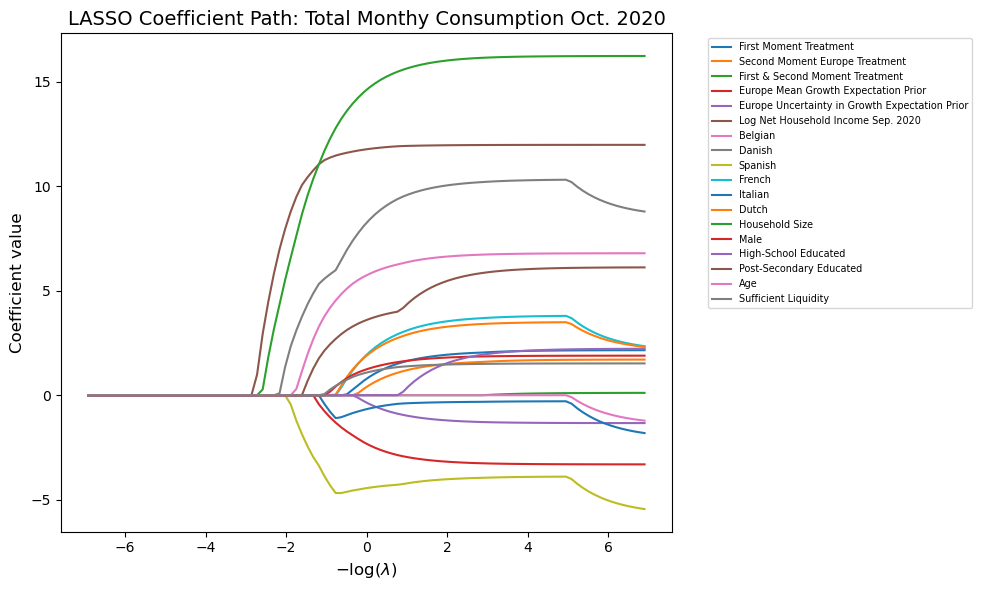

C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.506e+03, tolerance: 1.151e+03
  model = cd_fast.enet_coordinate_descent(


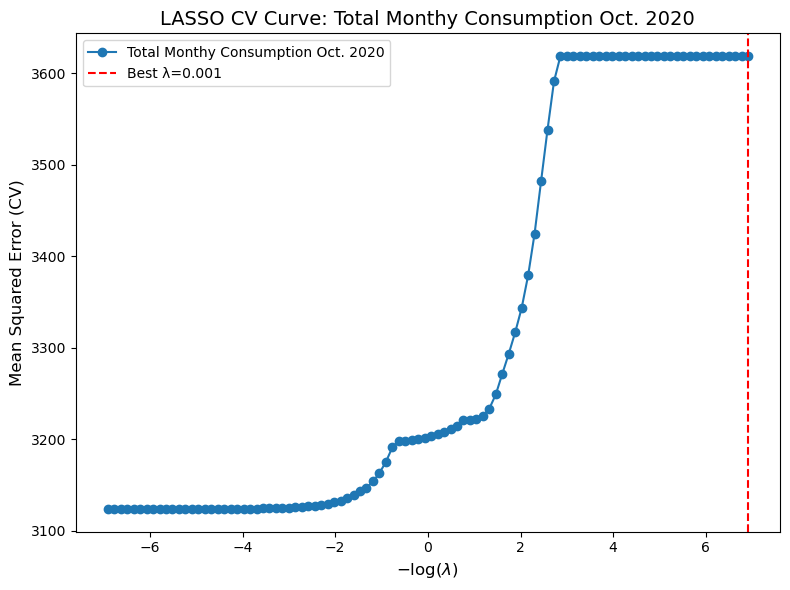

✅ Saved and displayed: lasso_wave10_coeff_path and lasso_wave10_cv_curve


C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.795e+03, tolerance: 1.243e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.796e+03, tolerance: 1.243e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.797e+03, tolerance: 

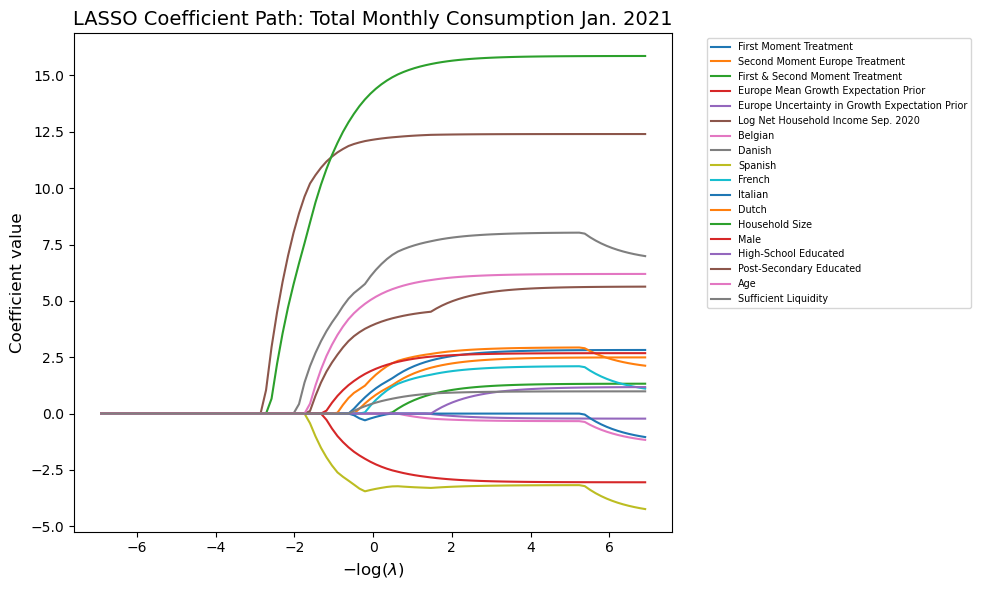

C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.795e+03, tolerance: 1.243e+03
  model = cd_fast.enet_coordinate_descent(


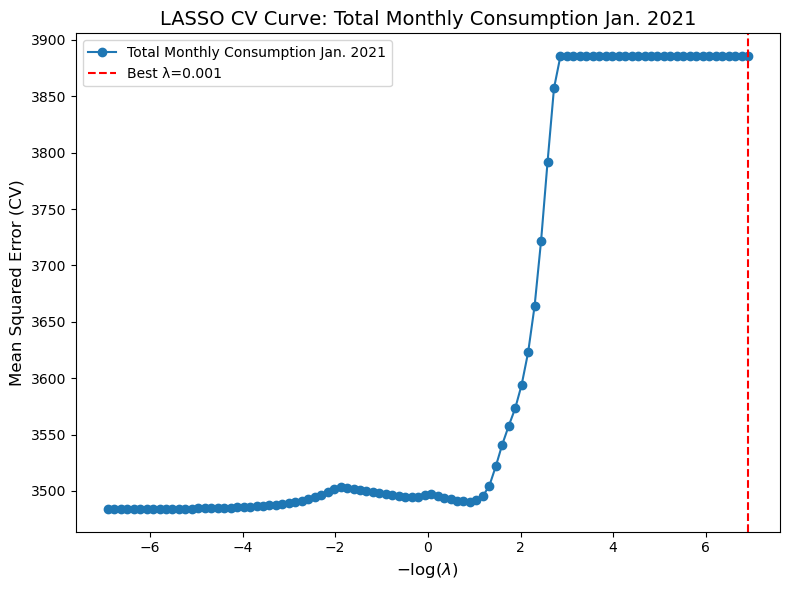

✅ Saved and displayed: lasso_wave13_coeff_path and lasso_wave13_cv_curve


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only rows with positive consumption
df = df[(df["Total Monthy Consumption Oct. 2020"] > 0) & 
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# Drop 'Second Moment Domestic Treatment' if exists
if "Second Moment Domestic Treatment" in df.columns:
    df = df.drop(columns=["Second Moment Domestic Treatment"])

# Filter out extreme consumption values
df_filtered = df[(df["Total Monthy Consumption Oct. 2020"] <= 10000) & 
                 (df["Total Monthly Consumption Jan. 2021"] <= 10000)]

# Define predictors
predictors = [col for col in df_filtered.columns if col not in [
    "Total Monthy Consumption Oct. 2020", 
    "Total Monthly Consumption Jan. 2021", 
    "Control Group"
]]

# Dependent variables
y1 = 100 * np.log(df_filtered["Total Monthy Consumption Oct. 2020"].astype(float))
y2 = 100 * np.log(df_filtered["Total Monthly Consumption Jan. 2021"].astype(float))

X_filtered = df_filtered[predictors].astype(float)

# Standardize predictors
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_filtered), columns=X_filtered.columns)

# LASSO settings
alphas = np.logspace(-3, 3, 100)

def lasso_path_and_cv(X, y, label, filename_prefix):
    # === Coefficient paths ===
    coefs = []
    for a in alphas:
        lasso = Lasso(alpha=a, max_iter=10000)
        lasso.fit(X, y)
        coefs.append(lasso.coef_)
    coefs = np.array(coefs)

    plt.figure(figsize=(10, 6))
    for i, col in enumerate(X.columns):
        plt.plot(-np.log(alphas), coefs[:, i], label=col)
    plt.xlabel(r"$-\log(\lambda)$", fontsize=12)
    plt.ylabel("Coefficient value", fontsize=12)
    plt.title(f"LASSO Coefficient Path: {label}", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="x-small")
    plt.tight_layout()
    plt.savefig(f"{filename_prefix}_coeff_path.pdf")
    plt.savefig(f"{filename_prefix}_coeff_path.png", dpi=300)
    plt.show()  # <-- Display the graph inline
    plt.close()

    # === Cross-validation curve ===
    lassocv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
    lassocv.fit(X, y)

    mse_mean = np.mean(lassocv.mse_path_, axis=1)
    plt.figure(figsize=(8, 6))
    plt.plot(-np.log(alphas), mse_mean, marker="o", label=f"{label}")
    plt.axvline(-np.log(lassocv.alpha_), linestyle="--", color="red", label=f"Best λ={lassocv.alpha_:.3f}")
    plt.xlabel(r"$-\log(\lambda)$", fontsize=12)
    plt.ylabel("Mean Squared Error (CV)", fontsize=12)
    plt.title(f"LASSO CV Curve: {label}", fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{filename_prefix}_cv_curve.pdf")
    plt.savefig(f"{filename_prefix}_cv_curve.png", dpi=300)
    plt.show()  # <-- Display the graph inline
    plt.close()

    print(f"✅ Saved and displayed: {filename_prefix}_coeff_path and {filename_prefix}_cv_curve")

# Run for both outcomes
lasso_path_and_cv(X_scaled, y1, "Total Monthy Consumption Oct. 2020", "lasso_wave10")
lasso_path_and_cv(X_scaled, y2, "Total Monthly Consumption Jan. 2021", "lasso_wave13")


C:\Users\Zach\AppData\Local\Temp\ipykernel_28124\424577592.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


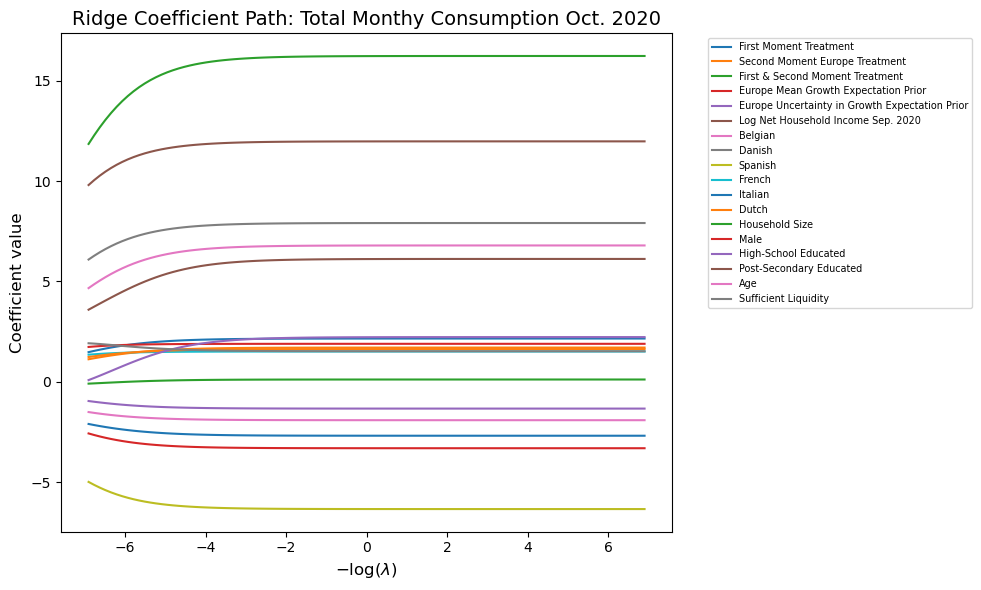

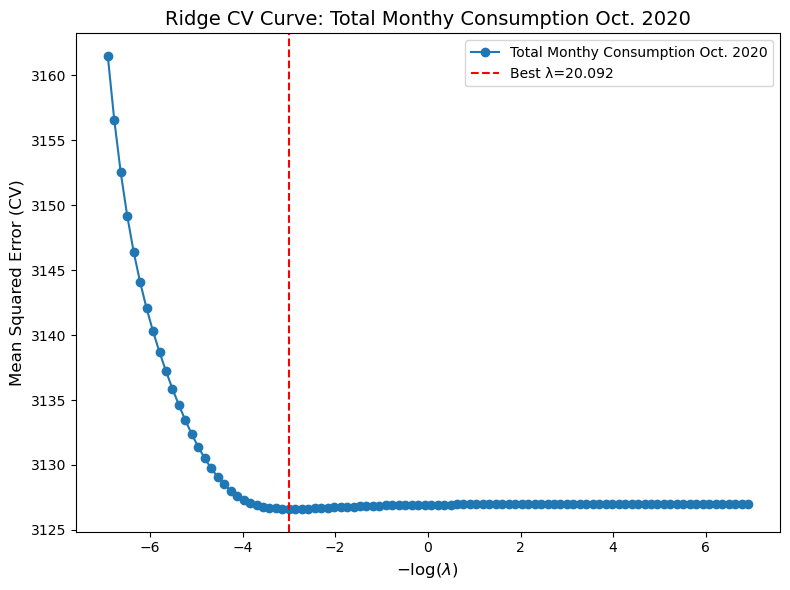

✅ Saved and displayed: ridge_wave10_coeff_path and ridge_wave10_cv_curve


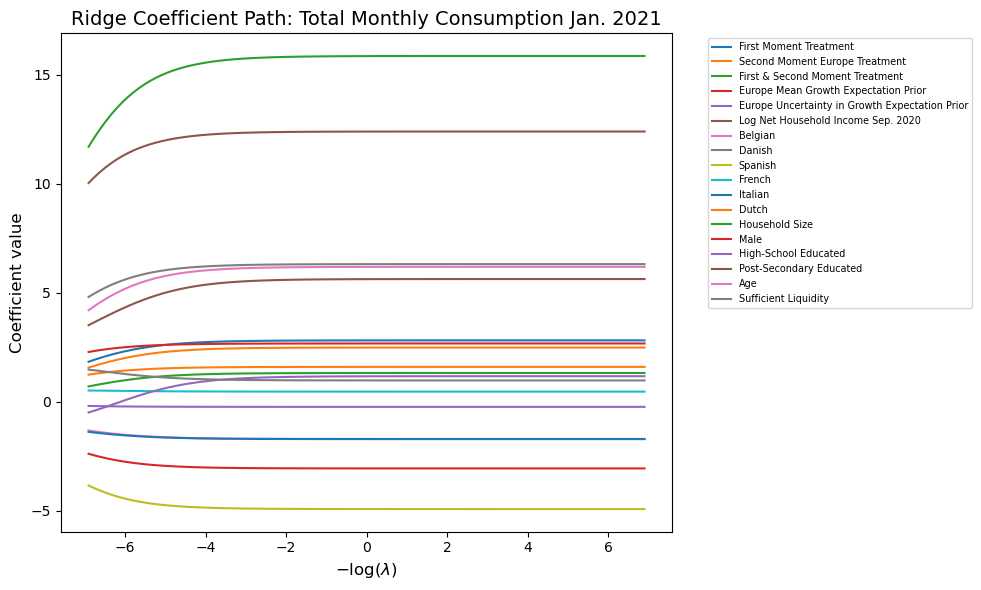

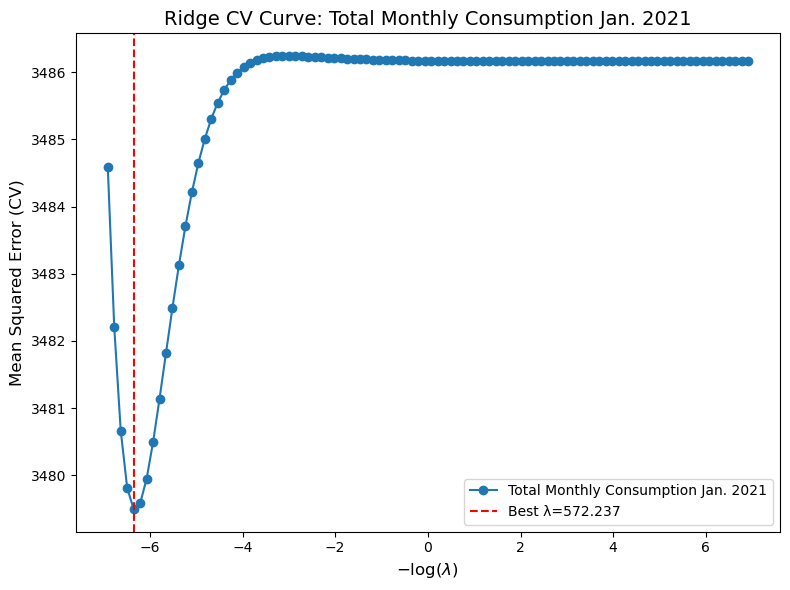

✅ Saved and displayed: ridge_wave13_coeff_path and ridge_wave13_cv_curve


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Load dataset
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only rows with positive consumption
df = df[(df["Total Monthy Consumption Oct. 2020"] > 0) & 
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# Drop 'Second Moment Domestic Treatment' if exists
if "Second Moment Domestic Treatment" in df.columns:
    df = df.drop(columns=["Second Moment Domestic Treatment"])

# Filter out extreme consumption values
df_filtered = df[(df["Total Monthy Consumption Oct. 2020"] <= 10000) & 
                 (df["Total Monthly Consumption Jan. 2021"] <= 10000)]

# Define predictors
predictors = [col for col in df_filtered.columns if col not in [
    "Total Monthy Consumption Oct. 2020", 
    "Total Monthly Consumption Jan. 2021", 
    "Control Group"
]]

# Dependent variables
y1 = 100 * np.log(df_filtered["Total Monthy Consumption Oct. 2020"].astype(float))
y2 = 100 * np.log(df_filtered["Total Monthly Consumption Jan. 2021"].astype(float))

X_filtered = df_filtered[predictors].astype(float)

# Standardize predictors
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_filtered), columns=X_filtered.columns)

# Ridge settings
alphas = np.logspace(-3, 3, 100)

def ridge_path_and_cv(X, y, label, filename_prefix):
    # === Coefficient paths ===
    coefs = []
    for a in alphas:
        ridge = Ridge(alpha=a, max_iter=10000)
        ridge.fit(X, y)
        coefs.append(ridge.coef_)
    coefs = np.array(coefs)

    plt.figure(figsize=(10, 6))
    for i, col in enumerate(X.columns):
        plt.plot(-np.log(alphas), coefs[:, i], label=col)
    plt.xlabel(r"$-\log(\lambda)$", fontsize=12)
    plt.ylabel("Coefficient value", fontsize=12)
    plt.title(f"Ridge Coefficient Path: {label}", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="x-small")
    plt.tight_layout()
    plt.savefig(f"{filename_prefix}_coeff_path.pdf")
    plt.savefig(f"{filename_prefix}_coeff_path.png", dpi=300)
    plt.show()
    plt.close()

    # === Cross-validation curve (manual) ===
    mse_mean = []
    for a in alphas:
        ridge = Ridge(alpha=a)
        scores = cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_squared_error')
        mse_mean.append(-scores.mean())
    mse_mean = np.array(mse_mean)
    best_alpha = alphas[np.argmin(mse_mean)]

    plt.figure(figsize=(8, 6))
    plt.plot(-np.log(alphas), mse_mean, marker="o", label=f"{label}")
    plt.axvline(-np.log(best_alpha), linestyle="--", color="red", label=f"Best λ={best_alpha:.3f}")
    plt.xlabel(r"$-\log(\lambda)$", fontsize=12)
    plt.ylabel("Mean Squared Error (CV)", fontsize=12)
    plt.title(f"Ridge CV Curve: {label}", fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{filename_prefix}_cv_curve.pdf")
    plt.savefig(f"{filename_prefix}_cv_curve.png", dpi=300)
    plt.show()
    plt.close()

    print(f"✅ Saved and displayed: {filename_prefix}_coeff_path and {filename_prefix}_cv_curve")

# Run for both outcomes
ridge_path_and_cv(X_scaled, y1, "Total Monthy Consumption Oct. 2020", "ridge_wave10")
ridge_path_and_cv(X_scaled, y2, "Total Monthly Consumption Jan. 2021", "ridge_wave13")


C:\Users\Zach\AppData\Local\Temp\ipykernel_28124\938505886.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


Test MSE: 1307331.59
Test RMSE: 1143.39
Test MAE: 811.02


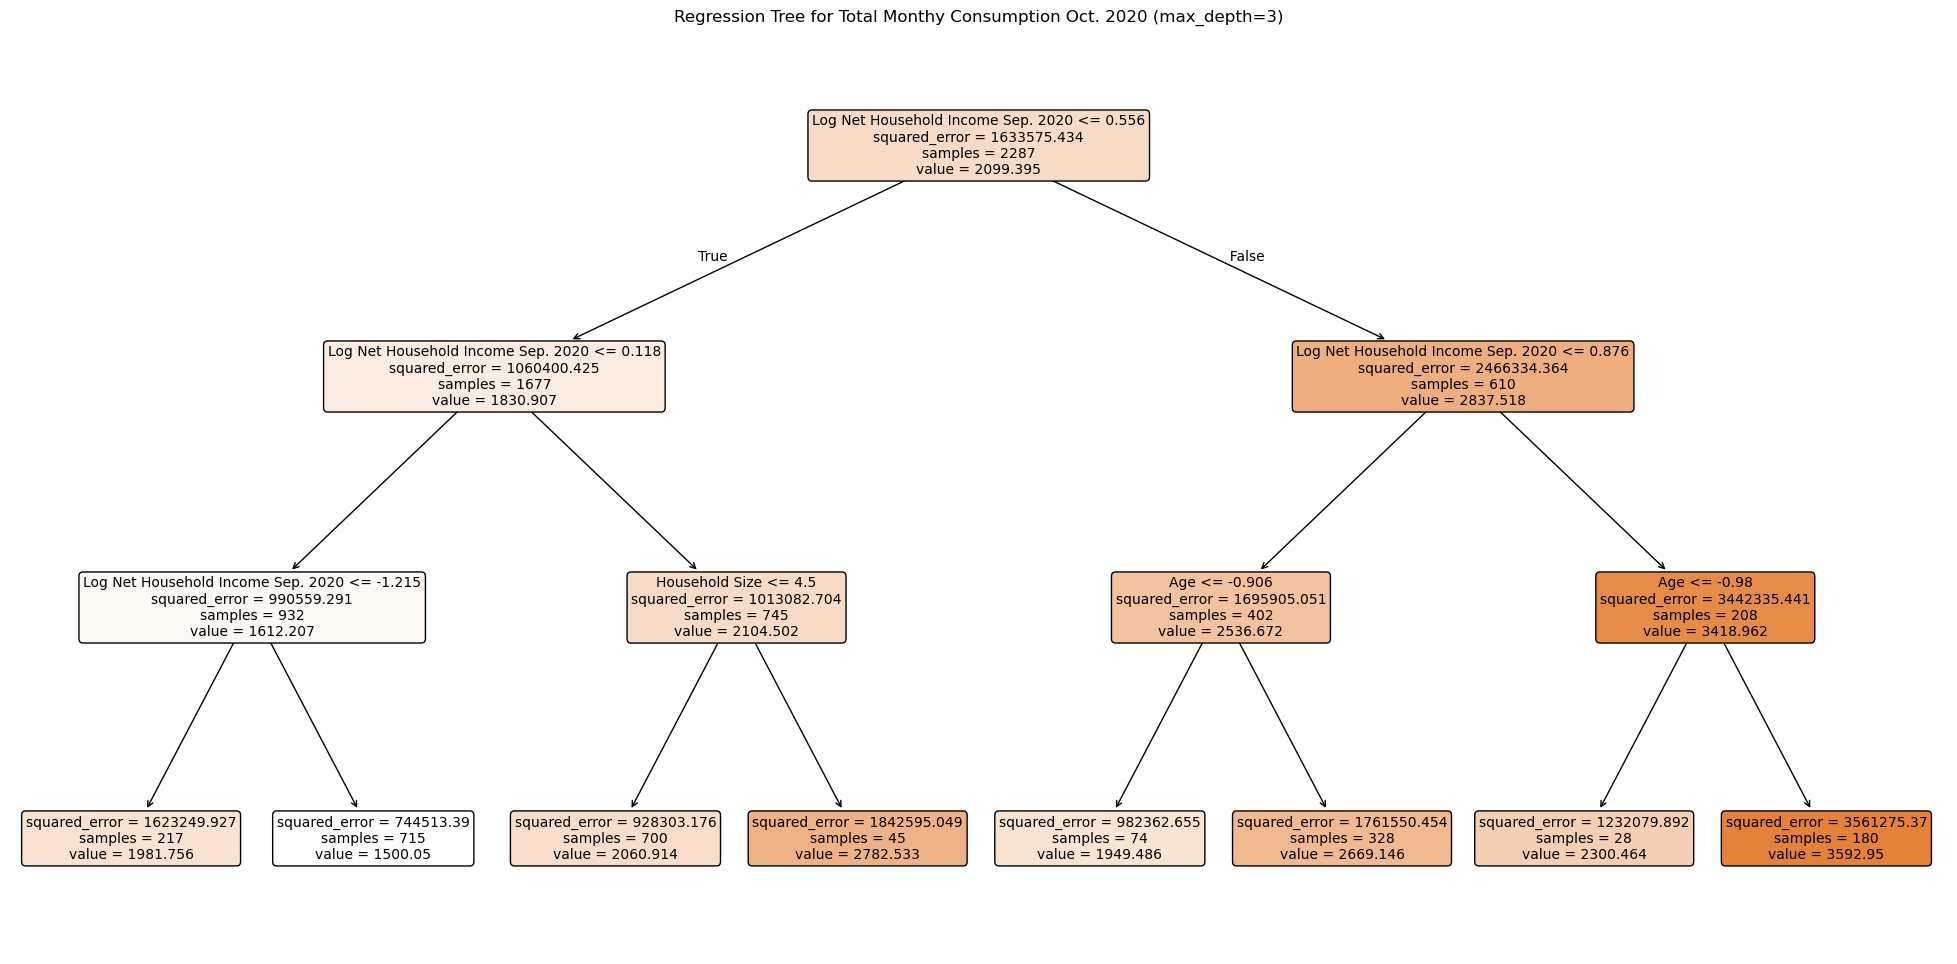

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# --- Load and preprocess data ---
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert booleans to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only positive consumption rows
df = df[df["Total Monthy Consumption Oct. 2020"] > 0].dropna()

# Drop 'Second Moment Domestic Treatment' if present
if "Second Moment Domestic Treatment" in df.columns:
    df = df.drop(columns=["Second Moment Domestic Treatment"])

# Filter out extreme values (>10,000)
df_filtered = df[df["Total Monthy Consumption Oct. 2020"] <= 10000]

# Define predictors (drop outcome, baseline Control Group, and next wave consumption)
predictors = [col for col in df_filtered.columns if col not in [
    "Total Monthy Consumption Oct. 2020", 
    "Control Group", 
    "Total Monthly Consumption Jan. 2021"
]]
X = df_filtered[predictors].astype(float)
y = df_filtered["Total Monthy Consumption Oct. 2020"].astype(float)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Train regression tree with max depth 3 ---
tree_max3 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_max3.fit(X_train, y_train)

# --- Predictions and evaluation ---
y_pred = tree_max3.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

# --- Plot the tree and save as PDF ---
plt.figure(figsize=(25, 12))  # wide & tall for readability
plot_tree(
    tree_max3,
    feature_names=list(X.columns),
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Regression Tree for Total Monthy Consumption Oct. 2020 (max_depth=3)")

# Save PDF for LaTeX
plt.savefig("regression_tree_max3.pdf", bbox_inches='tight')

# Display inline in Jupyter
plt.show()


C:\Users\Zach\AppData\Local\Temp\ipykernel_28124\4069907886.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


                                           Feature  Importance
5               Log Net Household Income Sep. 2020    0.305116
16                                             Age    0.150652
3             Europe Mean Growth Expectation Prior    0.148360
4   Europe Uncertainty in Growth Expectation Prior    0.112547
12                                  Household Size    0.072198
1                   Second Moment Europe Treatment    0.022961
7                                           Danish    0.021497
9                                           French    0.020521
13                                            Male    0.020356
0                           First Moment Treatment    0.017115
2                  First & Second Moment Treatment    0.016262
10                                         Italian    0.015274
15                         Post-Secondary Educated    0.014774
14                            High-School Educated    0.014206
17                            Sufficient Liquidity    0

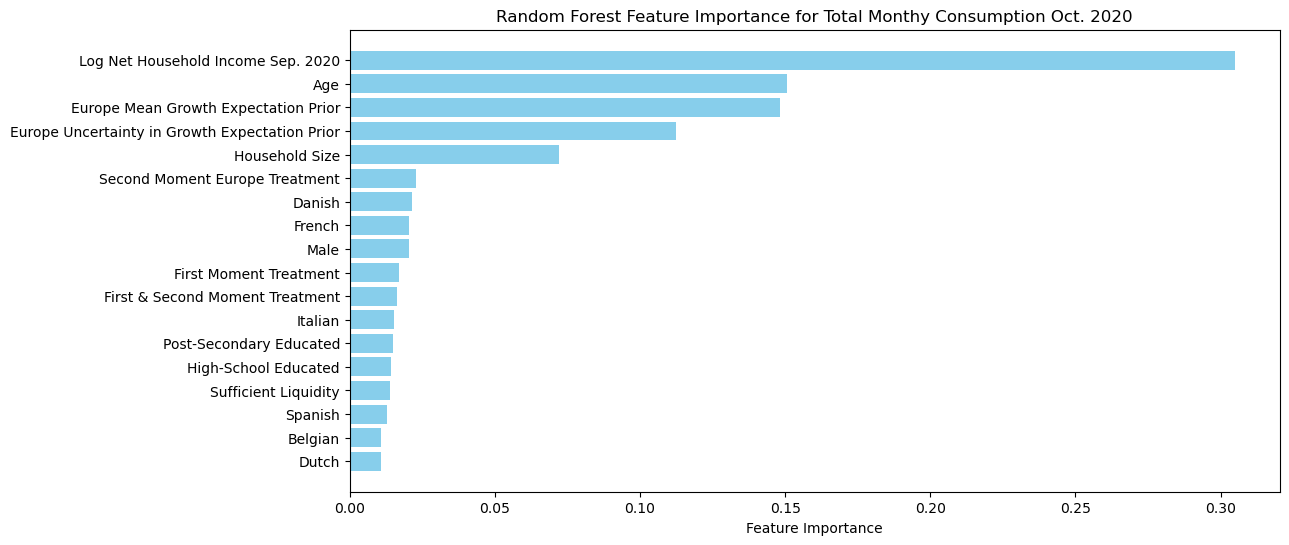

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# --- Load and preprocess data ---
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert booleans to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only positive consumption rows
df = df[df["Total Monthy Consumption Oct. 2020"] > 0].dropna()

# Drop 'Second Moment Domestic Treatment' if present
if "Second Moment Domestic Treatment" in df.columns:
    df = df.drop(columns=["Second Moment Domestic Treatment"])

# Filter out extreme values (>10,000)
df_filtered = df[df["Total Monthy Consumption Oct. 2020"] <= 10000]

# Define predictors (exclude outcome, baseline Control Group, and next wave consumption)
predictors = [col for col in df_filtered.columns if col not in [
    "Total Monthy Consumption Oct. 2020",
    "Control Group",
    "Total Monthly Consumption Jan. 2021"
]]
X = df_filtered[predictors].astype(float)
y = df_filtered["Total Monthy Consumption Oct. 2020"].astype(float)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Random Forest Regressor ---
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# --- Feature importances ---
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print feature importances
print(feature_importance_df)

# --- Plot feature importance ---
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # largest importance on top
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance for Total Monthy Consumption Oct. 2020')

# --- Save PDF for LaTeX ---
plt.savefig("random_forest_feature_importance.pdf", bbox_inches='tight')

# Display inline in Jupyter
plt.show()


C:\Users\Zach\AppData\Local\Temp\ipykernel_28124\2643287627.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


                                           Feature  Importance
5               Log Net Household Income Sep. 2020    0.301217
16                                             Age    0.152237
3             Europe Mean Growth Expectation Prior    0.145937
4   Europe Uncertainty in Growth Expectation Prior    0.113450
12                                  Household Size    0.070547
1                   Second Moment Europe Treatment    0.022664
10                                         Italian    0.021581
11                                           Dutch    0.020527
7                                           Danish    0.018815
14                            High-School Educated    0.018227
13                                            Male    0.018178
0                           First Moment Treatment    0.015985
2                  First & Second Moment Treatment    0.015884
15                         Post-Secondary Educated    0.015880
9                                           French    0

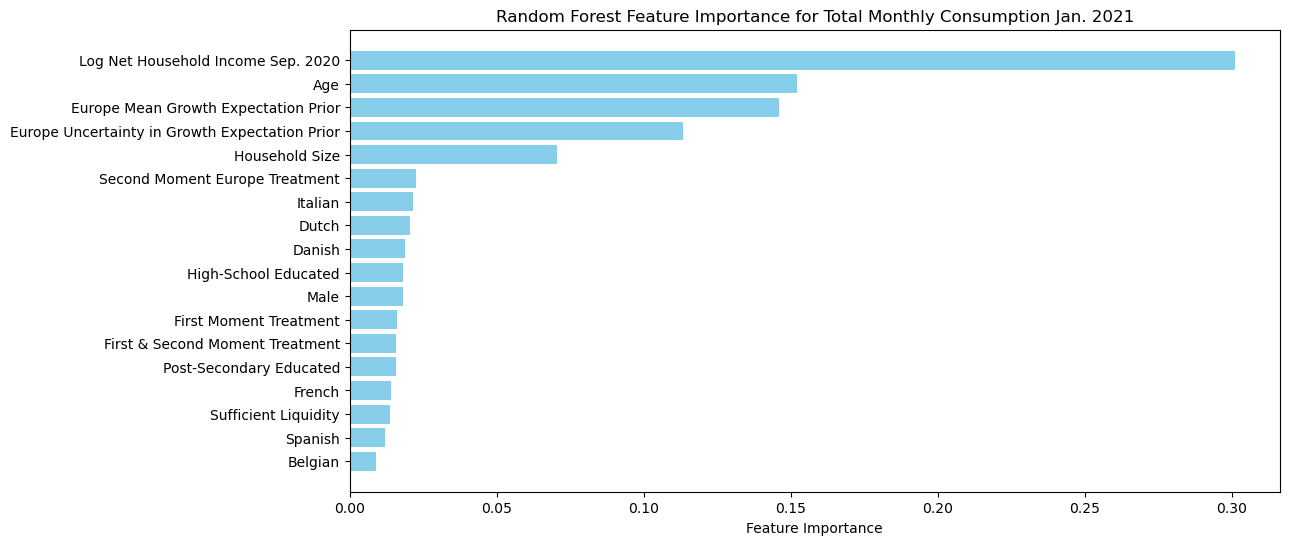

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# --- Load and preprocess data ---
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert booleans to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only positive consumption rows
df = df[df["Total Monthly Consumption Jan. 2021"] > 0].dropna()

# Drop 'Second Moment Domestic Treatment' if present
if "Second Moment Domestic Treatment" in df.columns:
    df = df.drop(columns=["Second Moment Domestic Treatment"])

# Filter out extreme values (>10,000)
df_filtered = df[df["Total Monthly Consumption Jan. 2021"] <= 10000]

# Define predictors (exclude outcome, baseline Control Group, and previous wave consumption)
predictors = [col for col in df_filtered.columns if col not in [
    "Total Monthly Consumption Jan. 2021",
    "Control Group",
    "Total Monthy Consumption Oct. 2020"
]]
X = df_filtered[predictors].astype(float)
y = df_filtered["Total Monthly Consumption Jan. 2021"].astype(float)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Random Forest Regressor ---
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# --- Feature importances ---
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print feature importances
print(feature_importance_df)

# --- Plot feature importance ---
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # largest importance on top
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance for Total Monthly Consumption Jan. 2021')

# Save PDF for LaTeX
plt.savefig("random_forest_feature_importance_jan2021.pdf", bbox_inches='tight')

# Display inline in Jupyter
plt.show()


C:\Users\Zach\AppData\Local\Temp\ipykernel_28124\621716902.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


Test MSE: 1462813.36
Test RMSE: 1209.47
Test MAE: 853.10


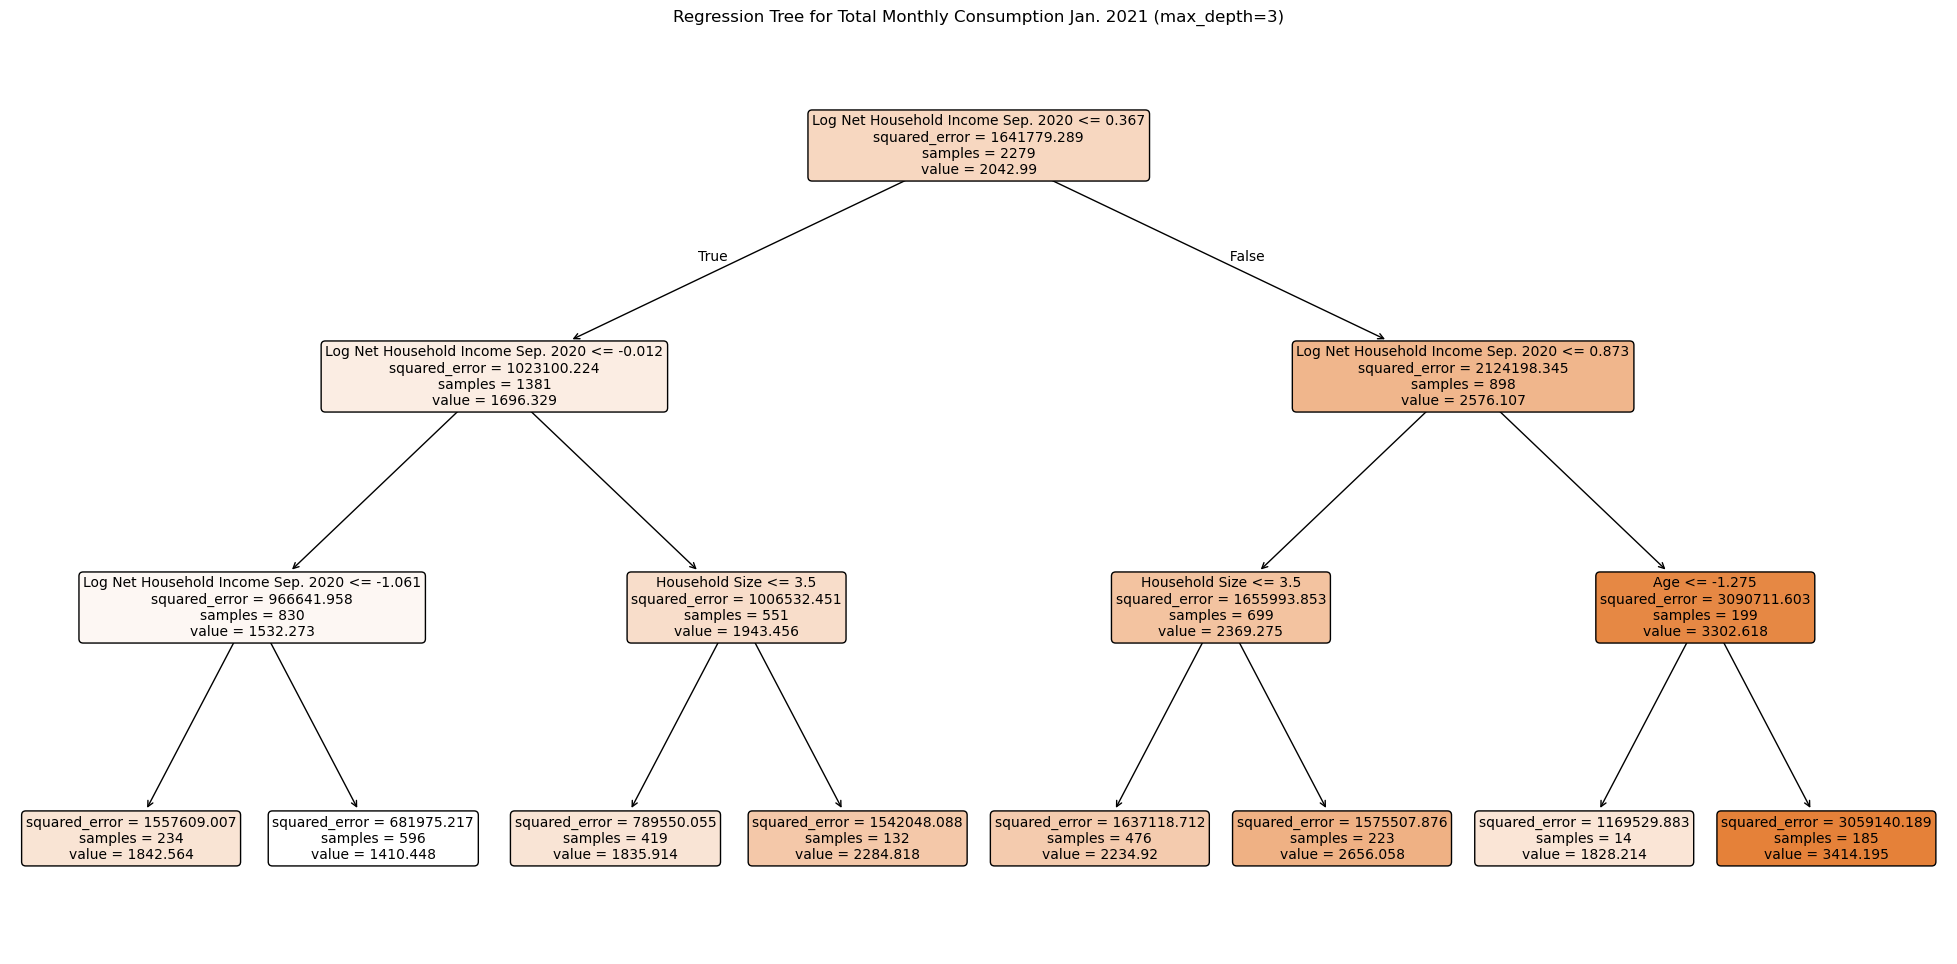

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# --- Load and preprocess data ---
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert booleans to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only positive consumption rows
df = df[df["Total Monthly Consumption Jan. 2021"] > 0].dropna()

# Drop 'Second Moment Domestic Treatment' if present
if "Second Moment Domestic Treatment" in df.columns:
    df = df.drop(columns=["Second Moment Domestic Treatment"])

# Filter out extreme values (>10,000)
df_filtered = df[df["Total Monthly Consumption Jan. 2021"] <= 10000]

# Define predictors (exclude outcome and baseline Control Group)
predictors = [col for col in df_filtered.columns if col not in [
    "Total Monthly Consumption Jan. 2021",
    "Control Group",
    "Total Monthy Consumption Oct. 2020"
]]
X = df_filtered[predictors].astype(float)
y = df_filtered["Total Monthly Consumption Jan. 2021"].astype(float)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Train regression tree with max depth 3 ---
tree_max3 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_max3.fit(X_train, y_train)

# --- Predictions and evaluation ---
y_pred = tree_max3.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

# --- Plot the tree ---
plt.figure(figsize=(25, 12))
plot_tree(
    tree_max3,
    feature_names=list(X.columns),
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Regression Tree for Total Monthly Consumption Jan. 2021 (max_depth=3)")

# Save PDF for LaTeX
plt.savefig("regression_tree_jan2021.pdf", bbox_inches='tight')

# Display inline in Jupyter
plt.show()


C:\Users\Zach\AppData\Local\Temp\ipykernel_28124\1068166877.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Quantile 0.1, Total Monthy Consumption Oct. 2020 interaction effect: -1.4798
Quantile 0.25, Total Monthy Consumption Oct. 2020 interaction effect: 7.4118
Quantile 0.5, Total Monthy Consumption Oct. 2020 interaction effect: -36.1477
Quantile 0.75, Total Monthy Consumption Oct. 2020 interaction effect: -134.7606
Quantile 0.9, Total Monthy Consumption Oct. 2020 interaction effect: -264.8324
Quantile 0.1, Total Monthly Consumption Jan. 2021 interaction effect: 17.4820
Quantile 0.25, Total Monthly Consumption Jan. 2021 interaction effect: 54.9391
Quantile 0.5, Total Monthly Consumption Jan. 2021 interaction effect: 32.8637
Quantile 0.75, Total Monthly Consumption Jan. 2021 interaction effect: -83.0675
Quantile 0.9, Total Monthly Consumption Jan. 2021 interaction effect: -290.8841


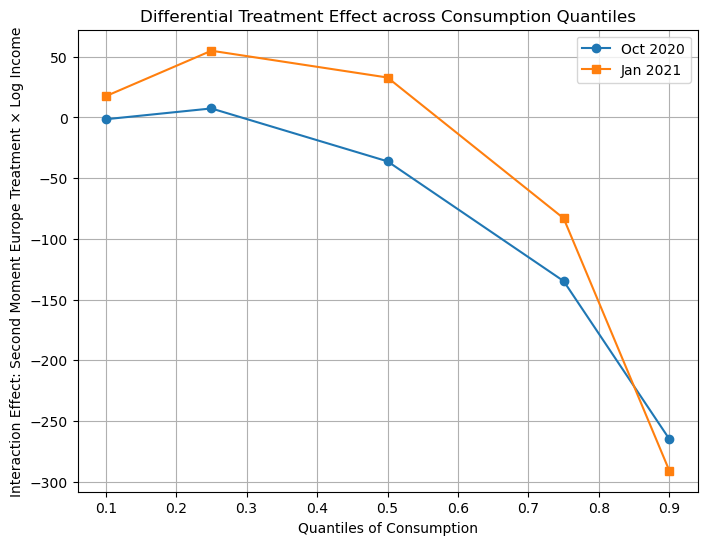

In [43]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert booleans to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Keep only positive consumption rows
df = df[(df["Total Monthy Consumption Oct. 2020"] > 0) &
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# Log-transform income
df["Log_Income"] = np.log(df["Log Net Household Income Sep. 2020"])

# Interaction term
df["SecondEurope_X_LogIncome"] = df["Second Moment Europe Treatment"] * df["Log_Income"]

# Controls
controls = ["Household Size", "Male", "Age", "Post-Secondary Educated", "Sufficient Liquidity"]

# Quantiles to estimate
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

# --- Function to run quantile regression and extract interaction effect ---
def run_quantile_regression(y_var, df):
    interaction_effects = []
    for q in quantiles:
        formula = (
            f'Q("{y_var}") ~ '
            'Q("Second Moment Europe Treatment") + Log_Income + SecondEurope_X_LogIncome + '
            + " + ".join([f'Q("{c}")' if " " in c else c for c in controls])
        )
        mod = smf.quantreg(formula, data=df)
        res = mod.fit(q=q)
        interaction_coef = res.params["SecondEurope_X_LogIncome"]
        interaction_effects.append(interaction_coef)
        print(f"Quantile {q}, {y_var} interaction effect: {interaction_coef:.4f}")
    return interaction_effects

# --- Run for Oct 2020 and Jan 2021 ---
interaction_oct = run_quantile_regression("Total Monthy Consumption Oct. 2020", df)
interaction_jan = run_quantile_regression("Total Monthly Consumption Jan. 2021", df)

# --- Plotting ---
plt.figure(figsize=(8,6))
plt.plot(quantiles, interaction_oct, marker="o", label="Oct 2020")
plt.plot(quantiles, interaction_jan, marker="s", label="Jan 2021")
plt.xlabel("Quantiles of Consumption")
plt.ylabel("Interaction Effect: Second Moment Europe Treatment × Log Income")
plt.title("Differential Treatment Effect across Consumption Quantiles")
plt.legend()
plt.grid(True)

# --- Save as PDF for LaTeX ---
plt.savefig("quantile_regression_interaction.pdf", bbox_inches='tight')

# --- Display inline in Jupyter ---
plt.show()


C:\Users\Zach\AppData\Local\Temp\ipykernel_28124\2822247788.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


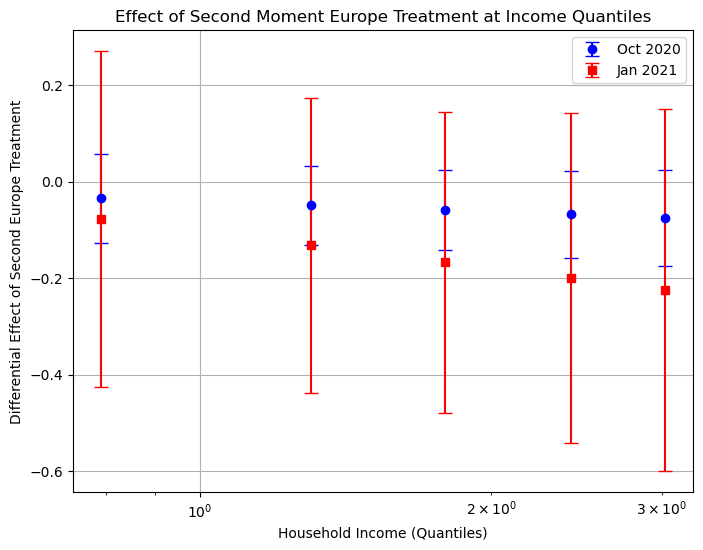

In [57]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Load dataset ---
df = pd.read_csv("CesDataClean3_subset_standardized3.csv")

# Convert booleans to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# --- Rename columns to simple names ---
df.rename(columns={
    "Total Monthy Consumption Oct. 2020": "TotalOct2020",
    "Total Monthly Consumption Jan. 2021": "TotalJan2021",
    "Second Moment Europe Treatment": "SecondEurope",
    "Log Net Household Income Sep. 2020": "LogIncome",
    "Household Size": "HouseholdSize",
    "Post-Secondary Educated": "PostSecondary",
    "Sufficient Liquidity": "Liquidity"
}, inplace=True)

# Keep only positive consumption rows
df = df[(df["TotalOct2020"] > 0) & (df["TotalJan2021"] > 0)].dropna()

# Interaction term
df["SecondEurope_X_LogIncome"] = df["SecondEurope"] * df["LogIncome"]

# Controls
controls = ["HouseholdSize", "Male", "Age", "PostSecondary", "Liquidity"]

# Quantiles to plot
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

# --- Function to compute marginal effect at given quantiles ---
def treatment_effect_at_quantiles(y_var, df, quantiles, ci=0.95):
    formula = f'{y_var} ~ SecondEurope + LogIncome + SecondEurope_X_LogIncome + ' + " + ".join(controls)
    model = smf.ols(formula, data=df).fit()
    
    income_values = df["LogIncome"].quantile(quantiles).values
    marginal_effect = model.params["SecondEurope"] + model.params["SecondEurope_X_LogIncome"] * income_values
    
    cov = model.cov_params()
    se = np.sqrt(
        cov.loc["SecondEurope", "SecondEurope"] +
        (income_values ** 2) * cov.loc["SecondEurope_X_LogIncome", "SecondEurope_X_LogIncome"] +
        2 * income_values * cov.loc["SecondEurope", "SecondEurope_X_LogIncome"]
    )
    
    z = norm.ppf(0.975)
    lower = marginal_effect - z * se
    upper = marginal_effect + z * se
    
    return income_values, marginal_effect, lower, upper

# --- Compute marginal effects for Oct 2020 ---
income_q_oct, effect_oct, lower_oct, upper_oct = treatment_effect_at_quantiles("TotalOct2020", df, quantiles)

# --- Compute marginal effects for Jan 2021 ---
income_q_jan, effect_jan, lower_jan, upper_jan = treatment_effect_at_quantiles("TotalJan2021", df, quantiles)

# --- Plot ---
plt.figure(figsize=(8,6))

# Oct 2020 points + CI
plt.errorbar(np.exp(income_q_oct), effect_oct, yerr=[effect_oct - lower_oct, upper_oct - effect_oct],
             fmt='o', color='blue', label="Oct 2020", capsize=5)

# Jan 2021 points + CI
plt.errorbar(np.exp(income_q_jan), effect_jan, yerr=[effect_jan - lower_jan, upper_jan - effect_jan],
             fmt='s', color='red', label="Jan 2021", capsize=5)

plt.xlabel("Household Income (Quantiles)")
plt.ylabel("Differential Effect of Second Europe Treatment")
plt.title("Effect of Second Moment Europe Treatment at Income Quantiles")
plt.xscale("log")
plt.grid(True)
plt.legend()

# --- Save PDF for LaTeX ---
plt.savefig("treatment_effect_vs_income_quantiles_points.pdf", bbox_inches='tight')

# --- Show inline ---
plt.show()


In [54]:
plt.figure(figsize=(8,6))
plt.plot(np.exp(income_percentiles), marginal_effect_oct, color='blue', label="Oct 2020")
plt.xlabel("Household Income")
plt.ylabel("Differential Effect of Second Moment Europe Treatment")
plt.title("Effect of Second Moment Europe Treatment across Income Levels")
plt.grid(True)
plt.legend()
plt.xscale("log")  # optional, since Log_Income is used
plt.savefig("treatment_effect_vs_income.pdf", bbox_inches='tight')
plt.show()


NameError: name 'marginal_effect_oct' is not defined

<Figure size 800x600 with 0 Axes>

C:\Users\Zach\AppData\Local\Temp\ipykernel_28124\1643921115.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


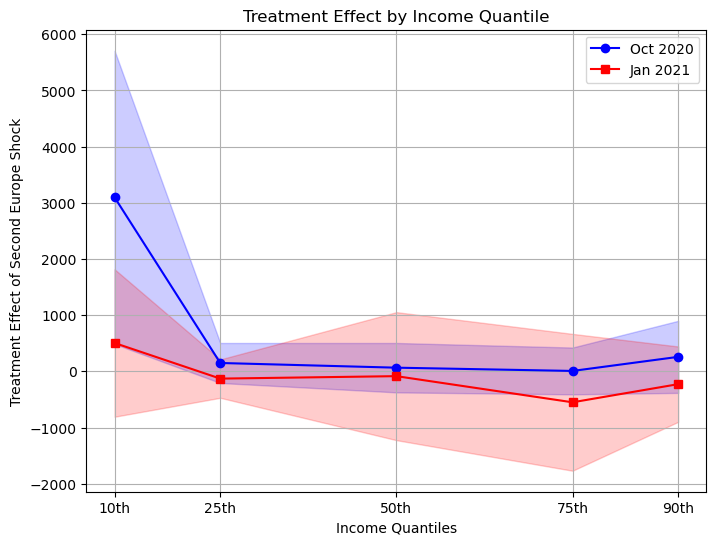

In [60]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert booleans to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# --- Rename columns ---
df.rename(columns={
    "Total Monthy Consumption Oct. 2020": "TotalOct2020",
    "Total Monthly Consumption Jan. 2021": "TotalJan2021",
    "Second Moment Europe Treatment": "SecondEurope",
    "Log Net Household Income Sep. 2020": "LogIncome",
    "Household Size": "HouseholdSize",
    "Post-Secondary Educated": "PostSecondary",
    "Sufficient Liquidity": "Liquidity"
}, inplace=True)

# Keep only positive consumption rows
df = df[(df["TotalOct2020"] > 0) & (df["TotalJan2021"] > 0)].dropna()

# Controls
controls = ["HouseholdSize", "Male", "Age", "PostSecondary", "Liquidity"]

# Quantiles to explore
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
income_values = df["LogIncome"].quantile(quantiles).values

# --- Function to estimate treatment effect within each quantile ---
def treatment_effect_by_income_quantile(y_var, df, income_values, controls):
    effects = []
    lower_ci = []
    upper_ci = []
    
    for val in income_values:
        window = 0.05  # 5% log-income window around quantile
        subset = df[(df["LogIncome"] >= val - window) & (df["LogIncome"] <= val + window)]
        X = subset[["SecondEurope"] + controls]
        X = sm.add_constant(X)
        y = subset[y_var]
        if len(subset) < 5:
            effects.append(np.nan)
            lower_ci.append(np.nan)
            upper_ci.append(np.nan)
            continue
        model = sm.OLS(y, X).fit()
        eff = model.params["SecondEurope"]
        se = model.bse["SecondEurope"]
        effects.append(eff)
        z = 1.96  # 95% CI
        lower_ci.append(eff - z*se)
        upper_ci.append(eff + z*se)
        
    return np.array(effects), np.array(lower_ci), np.array(upper_ci)

# --- Oct 2020 ---
effect_oct, lower_oct, upper_oct = treatment_effect_by_income_quantile(
    "TotalOct2020", df, income_values, controls
)

# --- Jan 2021 ---
effect_jan, lower_jan, upper_jan = treatment_effect_by_income_quantile(
    "TotalJan2021", df, income_values, controls
)

# --- Plot ---
plt.figure(figsize=(8,6))

# Oct 2020 line + points + CI
plt.plot(quantiles, effect_oct, '-o', color='blue', label="Oct 2020")
plt.fill_between(quantiles, lower_oct, upper_oct, color='blue', alpha=0.2)

# Jan 2021 line + points + CI
plt.plot(quantiles, effect_jan, '-s', color='red', label="Jan 2021")
plt.fill_between(quantiles, lower_jan, upper_jan, color='red', alpha=0.2)

plt.xlabel("Income Quantiles")
plt.xticks(quantiles, ['10th', '25th', '50th', '75th', '90th'])
plt.ylabel("Treatment Effect of Second Europe Shock")
plt.title("Treatment Effect by Income Quantile")
plt.grid(True)
plt.legend()

# --- Save PDF for LaTeX ---
plt.savefig("treatment_effect_by_income_quantile_line.pdf", bbox_inches='tight')

# --- Show inline ---
plt.show()


In [61]:
import pandas as pd

# Load your dataset
data = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Generate summary statistics for numeric variables
summary = data.describe().T
summary = summary.rename(columns={
    "count": "N",
    "mean": "Mean",
    "std": "Std. Dev.",
    "min": "Min",
    "25%": "P25",
    "50%": "Median",
    "75%": "P75",
    "max": "Max"
})

# Round for readability
summary = summary.round(3)

# Display in Jupyter (nicely formatted)
display(summary)

# --- Export LaTeX table ---
latex_table = summary.to_latex(
    index=True,
    caption="Summary Statistics",
    label="tab:summary_stats",
    column_format="lcccccccc",  # left align first column, center others
    escape=False
)

# Save as .tex file
with open("summary_statistics.tex", "w") as f:
    f.write(latex_table)

print("\n✅ LaTeX table saved as 'summary_statistics.tex' — ready for Overleaf!")



,N,Mean,Std. Dev.,Min,P25,Median,P75,Max
Total Monthy Consumption Oct. 2020,3309.0,2381.750,9001.624,0.000,1220.000,1800.000,2621.000,501150.000
Total Monthly Consumption Jan. 2021,3309.0,2234.561,2706.234,0.000,1200.000,1760.000,2550.000,87550.000
Control Group,3309.0,0.205,0.403,0.000,0.000,0.000,0.000,1.000
First Moment Treatment,3309.0,0.193,0.395,0.000,0.000,0.000,0.000,1.000
Second Moment Europe Treatment,3309.0,0.209,0.407,0.000,0.000,0.000,0.000,1.000
First & Second Moment Treatment,3309.0,0.198,0.399,0.000,0.000,0.000,0.000,1.000
Second Moment Domestic Treatment,3309.0,0.196,0.397,0.000,0.000,0.000,0.000,1.000
Europe Mean Growth Expectation Prior,3309.0,0.000,1.000,-5.486,-0.508,0.051,0.498,4.972
Europe Uncertainty in Growth Expectation Prior,3309.0,0.000,1.000,-0.914,-0.610,-0.305,0.304,9.132
Log Net Household Income Sep. 2020,3309.0,0.000,1.000,-8.077,-0.234,0.212,0.582,3.027



✅ LaTeX table saved as 'summary_statistics.tex' — ready for Overleaf!


In [62]:
import pandas as pd

# Load your dataset
data = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Generate summary statistics for numeric variables
summary = data.describe().T
summary = summary.rename(columns={
    "count": "N",
    "mean": "Mean",
    "std": "Std. Dev.",
    "min": "Min",
    "25%": "P25",
    "50%": "Median",
    "75%": "P75",
    "max": "Max"
})

# Round all numbers to 2 decimals
summary = summary.round(2)

# Display in Jupyter Notebook
display(summary)

# --- Export LaTeX table ---
latex_table = summary.to_latex(
    index=True,
    caption="Summary Statistics",
    label="tab:summary_stats",
    column_format="lcccccccc",  # left-align first column, center others
    escape=False
)

# Save as .tex file
with open("summary_statistics2.tex", "w") as f:
    f.write(latex_table)

print("\n✅ LaTeX table saved as 'summary_statistics.tex' — ready for Overleaf!")


,N,Mean,Std. Dev.,Min,P25,Median,P75,Max
Total Monthy Consumption Oct. 2020,3309.0,2381.75,9001.62,0.00,1220.00,1800.00,2621.00,501150.00
Total Monthly Consumption Jan. 2021,3309.0,2234.56,2706.23,0.00,1200.00,1760.00,2550.00,87550.00
Control Group,3309.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
First Moment Treatment,3309.0,0.19,0.39,0.00,0.00,0.00,0.00,1.00
Second Moment Europe Treatment,3309.0,0.21,0.41,0.00,0.00,0.00,0.00,1.00
First & Second Moment Treatment,3309.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
Second Moment Domestic Treatment,3309.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
Europe Mean Growth Expectation Prior,3309.0,0.00,1.00,-5.49,-0.51,0.05,0.50,4.97
Europe Uncertainty in Growth Expectation Prior,3309.0,0.00,1.00,-0.91,-0.61,-0.31,0.30,9.13
Log Net Household Income Sep. 2020,3309.0,0.00,1.00,-8.08,-0.23,0.21,0.58,3.03



✅ LaTeX table saved as 'summary_statistics.tex' — ready for Overleaf!


In [64]:
import pandas as pd

# Load dataset
data = pd.read_csv("CesDataClean3_subset.csv")

# Generate summary statistics
summary = data.describe().T
summary = summary.rename(columns={
    "count": "N",
    "mean": "Mean",
    "std": "Std. Dev.",
    "min": "Min",
    "25%": "P25",
    "50%": "Median",
    "75%": "P75",
    "max": "Max"
})

# Round numeric values to 2 decimals for both Jupyter and LaTeX
summary_rounded = summary.copy()
for col in summary_rounded.columns:
    if col != "N":  # leave count as integer
        summary_rounded[col] = summary_rounded[col].map(lambda x: f"{x:.2f}")

# Display nicely in Jupyter
display(summary_rounded)

# --- Export LaTeX table ---
latex_table = summary_rounded.to_latex(
    index=True,
    caption="Summary Statistics",
    label="tab:summary_stats",
    column_format="lcccccccc",
    escape=False
)

# Save as .tex
with open("summary_statistics4.tex", "w") as f:
    f.write(latex_table)

print("\n✅ LaTeX table saved as 'summary_statistics.tex' with values rounded to 2 decimals.")


,N,Mean,Std. Dev.,Min,P25,Median,P75,Max
cons_tot_wave10,3309.0,2381.75,9001.62,0.00,1220.00,1800.00,2621.00,501150.00
cons_tot_wave13,3309.0,2234.56,2706.23,0.00,1200.00,1760.00,2550.00,87550.00
treat1,3309.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
treat2,3309.0,0.19,0.39,0.00,0.00,0.00,0.00,1.00
treat3,3309.0,0.21,0.41,0.00,0.00,0.00,0.00,1.00
treat4,3309.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
treat5,3309.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
egrea_imean_bt,3309.0,0.55,8.94,-48.50,-4.00,1.00,5.00,45.00
egrea_istd_bt,3309.0,2.04,2.01,0.20,0.82,1.43,2.65,20.41
lhhnetinc,3309.0,10.17,1.12,1.10,9.90,10.40,10.82,13.56



✅ LaTeX table saved as 'summary_statistics.tex' with values rounded to 2 decimals.


In [65]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

# Load data
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert booleans to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric where possible
df = df.apply(pd.to_numeric, errors="coerce")

# Drop rows with missing or non-positive consumption (log requires >0)
df = df[(df["Total Monthy Consumption Oct. 2020"] > 0) & (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# Drop Second Moment Domestic Treatment if it exists
if "Second Moment Domestic Treatment" in df.columns:
    df = df.drop(columns=["Second Moment Domestic Treatment"])

# Filter out rows where outcome > 10,000
df_filtered = df[(df["Total Monthy Consumption Oct. 2020"] <= 10000) & (df["Total Monthly Consumption Jan. 2021"] <= 10000)]

# Define predictors (drop Control Group so it's the baseline)
predictors = [col for col in df_filtered.columns if col not in ["Total Monthy Consumption Oct. 2020",
                                                                "Total Monthly Consumption Jan. 2021",
                                                                "Control Group"]]

# === Add interaction term ===
df_filtered["EuropeTreat_x_Income"] = df_filtered["Second Moment Europe Treatment"] * df_filtered["Log Net Household Income Sep. 2020"]
predictors.append("EuropeTreat_x_Income")  # Include interaction in predictors

# Prepare dependent variables (log * 100)
y1 = 100 * np.log(df_filtered["Total Monthy Consumption Oct. 2020"].astype(float))
y2 = 100 * np.log(df_filtered["Total Monthly Consumption Jan. 2021"].astype(float))

# Build models
X = sm.add_constant(df_filtered[predictors].astype(float))
model1 = sm.OLS(y1, X).fit(cov_type="HC3")  # Robust SEs
model2 = sm.OLS(y2, X).fit(cov_type="HC3")

# Create Stargazer table
stargazer = Stargazer([model1, model2])

# === Formatting ===
stargazer.title("Determinants of Monthly Consumption")
stargazer.custom_columns(["Oct. 2020", "Jan. 2021"], [1, 1])
stargazer.significance_levels([0.1, 0.05, 0.01])
stargazer.covariate_order(predictors)
stargazer.significant_digits(3)  # Round to 3 decimals for neatness
stargazer.add_line("Controls", ["Yes", "Yes"])

# Generate LaTeX
latex_table = stargazer.render_latex()

# Save to file
with open("consumption_regressions_econstyle2.tex", "w") as f:
    f.write(latex_table)

print("✅ LaTeX table saved as 'consumption_regressions_econstyle.tex'")


C:\Users\Zach\AppData\Local\Temp\ipykernel_28124\319254578.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\AppData\Local\Temp\ipykernel_28124\319254578.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["EuropeTreat_x_Income"] = df_filtered["Second Moment Europe Treatment"] * df_filtered["Log Net Household Income Sep. 2020"]


✅ LaTeX table saved as 'consumption_regressions_econstyle.tex'


C:\Users\Zach\AppData\Local\Temp\ipykernel_28124\2460918553.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.506e+03, tolerance: 1.151e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.507e+03, tolerance: 1.151e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zach\anaconda3\Lib\site-packages\sk

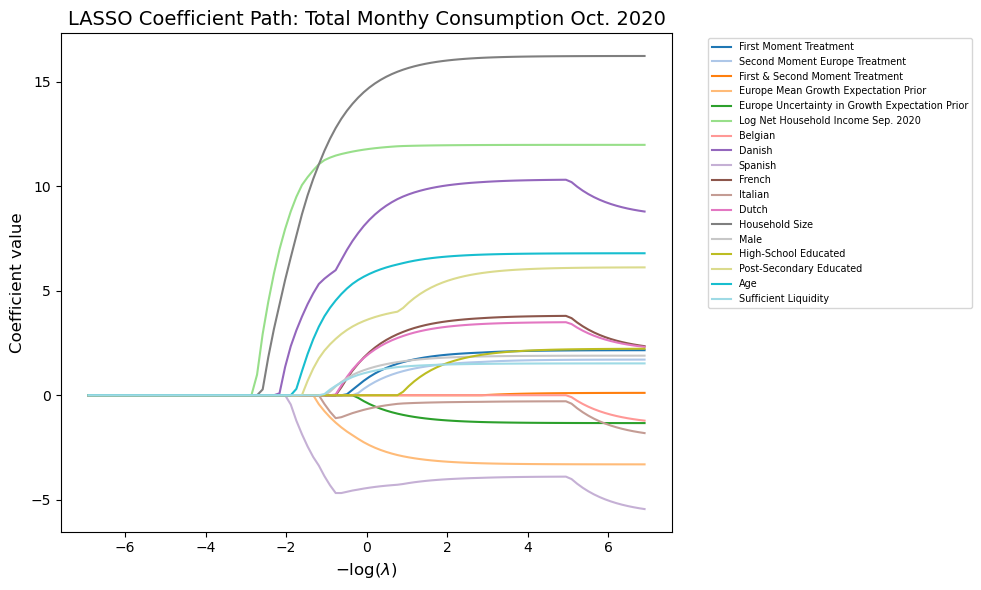

C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.506e+03, tolerance: 1.151e+03
  model = cd_fast.enet_coordinate_descent(


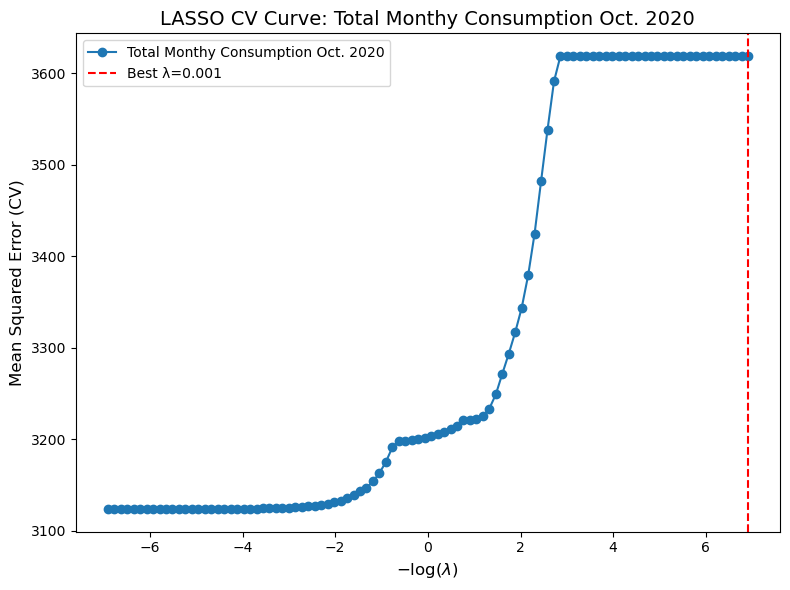

✅ Saved and displayed: lasso_wave10_coeff_path and lasso_wave10_cv_curve


C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.795e+03, tolerance: 1.243e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.796e+03, tolerance: 1.243e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.797e+03, tolerance: 

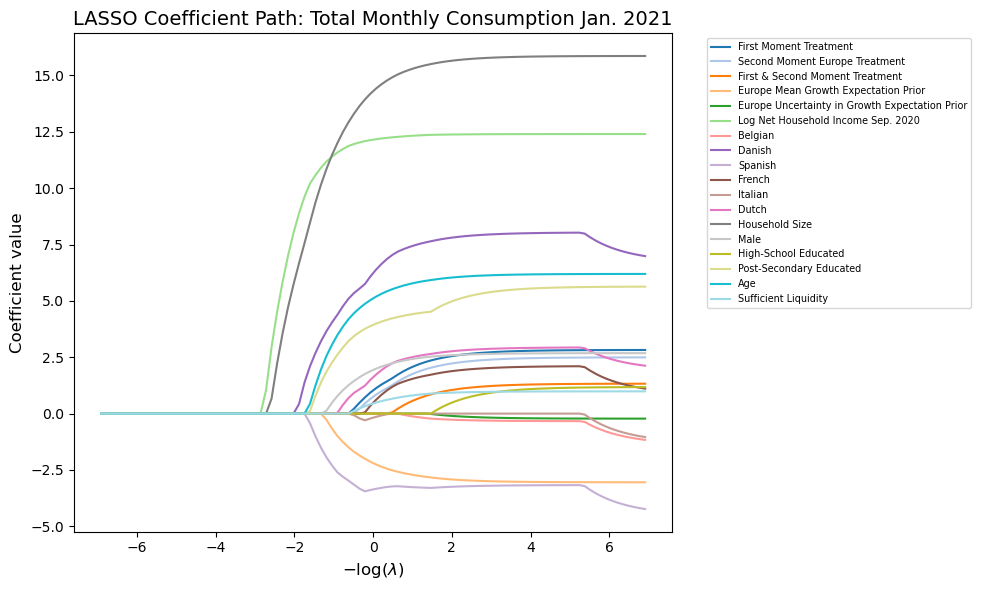

C:\Users\Zach\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.795e+03, tolerance: 1.243e+03
  model = cd_fast.enet_coordinate_descent(


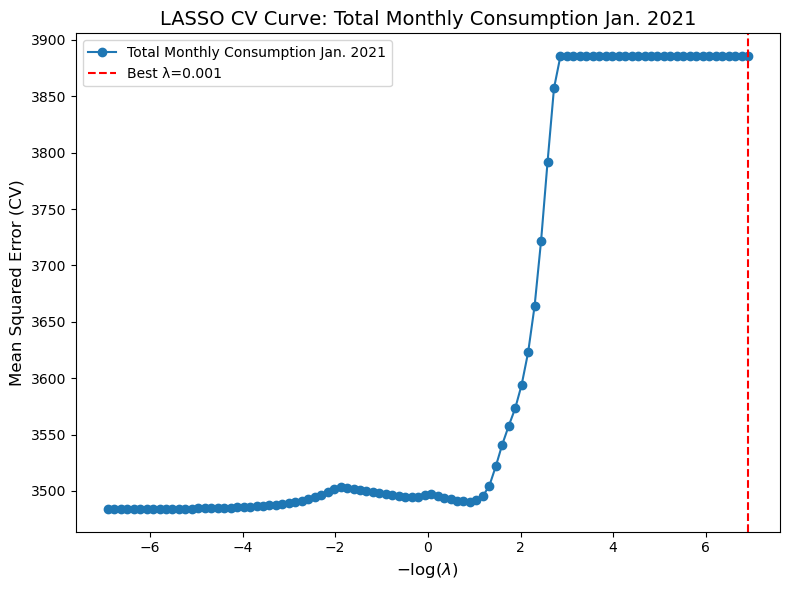

✅ Saved and displayed: lasso_wave13_coeff_path and lasso_wave13_cv_curve


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm

# Load the dataset
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only rows with positive consumption
df = df[(df["Total Monthy Consumption Oct. 2020"] > 0) & 
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# Drop 'Second Moment Domestic Treatment' if exists
if "Second Moment Domestic Treatment" in df.columns:
    df = df.drop(columns=["Second Moment Domestic Treatment"])

# Filter out extreme consumption values
df_filtered = df[(df["Total Monthy Consumption Oct. 2020"] <= 10000) & 
                 (df["Total Monthly Consumption Jan. 2021"] <= 10000)]

# Define predictors
predictors = [col for col in df_filtered.columns if col not in [
    "Total Monthy Consumption Oct. 2020", 
    "Total Monthly Consumption Jan. 2021", 
    "Control Group"
]]

# Dependent variables
y1 = 100 * np.log(df_filtered["Total Monthy Consumption Oct. 2020"].astype(float))
y2 = 100 * np.log(df_filtered["Total Monthly Consumption Jan. 2021"].astype(float))

X_filtered = df_filtered[predictors].astype(float)

# Standardize predictors
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_filtered), columns=X_filtered.columns)

# LASSO settings
alphas = np.logspace(-3, 3, 100)

def lasso_path_and_cv(X, y, label, filename_prefix):
    # === Coefficient paths ===
    coefs = []
    for a in alphas:
        lasso = Lasso(alpha=a, max_iter=10000)
        lasso.fit(X, y)
        coefs.append(lasso.coef_)
    coefs = np.array(coefs)

    plt.figure(figsize=(10, 6))

    # Generate enough distinct colors
    n_vars = X.shape[1]
    colors = cm.tab20(np.linspace(0, 1, min(n_vars, 20)))  # tab20 has 20 distinct colors

    for i, col in enumerate(X.columns):
        plt.plot(-np.log(alphas), coefs[:, i], 
                 label=col, 
                 color=colors[i % 20])  # cycle if >20 variables

    plt.xlabel(r"$-\log(\lambda)$", fontsize=12)
    plt.ylabel("Coefficient value", fontsize=12)
    plt.title(f"LASSO Coefficient Path: {label}", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="x-small")
    plt.tight_layout()
    plt.savefig(f"{filename_prefix}_coeff_path.pdf")
    plt.savefig(f"{filename_prefix}_coeff_path.png", dpi=300)
    plt.show()
    plt.close()

    # === Cross-validation curve ===
    lassocv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
    lassocv.fit(X, y)

    mse_mean = np.mean(lassocv.mse_path_, axis=1)
    plt.figure(figsize=(8, 6))
    plt.plot(-np.log(alphas), mse_mean, marker="o", label=f"{label}")
    plt.axvline(-np.log(lassocv.alpha_), linestyle="--", color="red", label=f"Best λ={lassocv.alpha_:.3f}")
    plt.xlabel(r"$-\log(\lambda)$", fontsize=12)
    plt.ylabel("Mean Squared Error (CV)", fontsize=12)
    plt.title(f"LASSO CV Curve: {label}", fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{filename_prefix}_cv_curve.pdf")
    plt.savefig(f"{filename_prefix}_cv_curve.png", dpi=300)
    plt.show()
    plt.close()

    print(f"✅ Saved and displayed: {filename_prefix}_coeff_path and {filename_prefix}_cv_curve")

# Run for both outcomes
lasso_path_and_cv(X_scaled, y1, "Total Monthy Consumption Oct. 2020", "lasso_wave10")
lasso_path_and_cv(X_scaled, y2, "Total Monthly Consumption Jan. 2021", "lasso_wave13")


C:\Users\Zach\AppData\Local\Temp\ipykernel_28124\1716272290.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


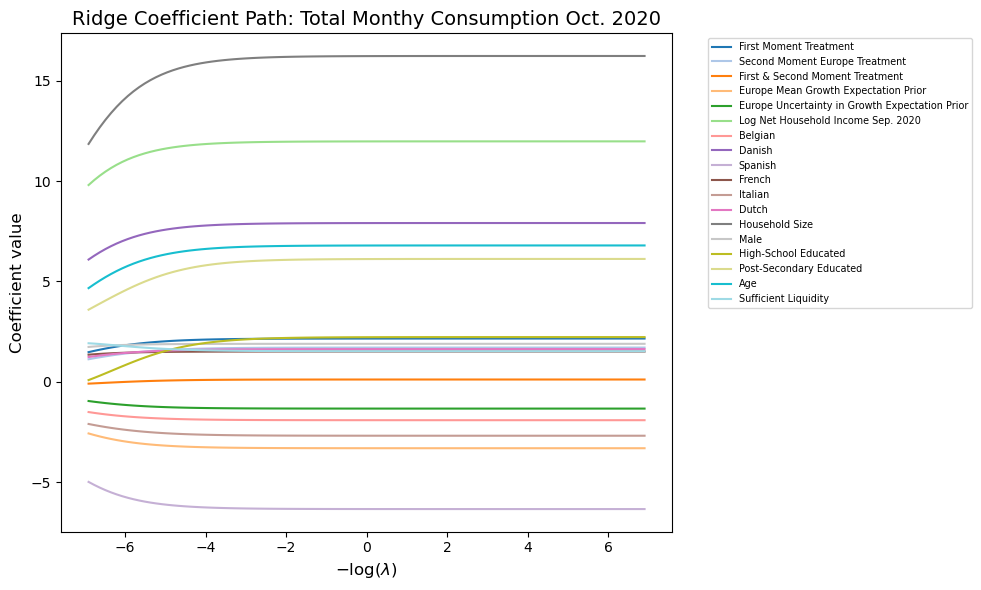

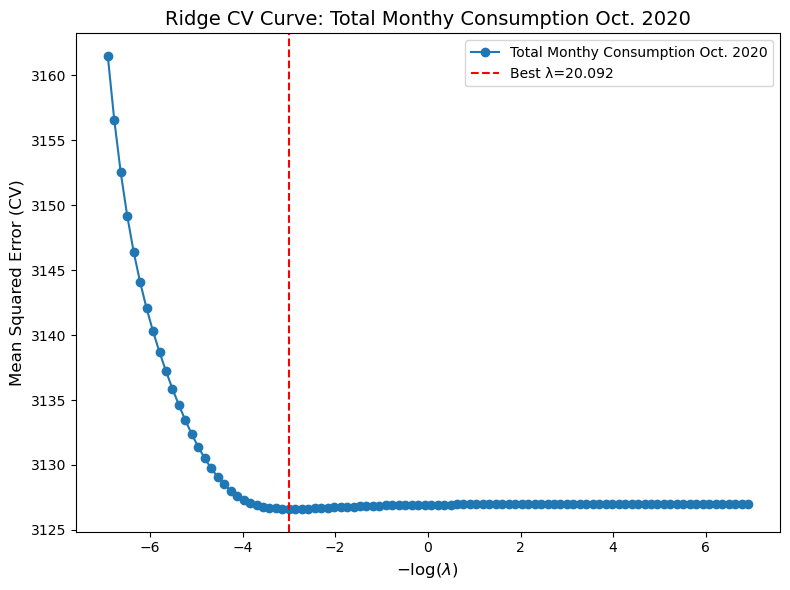

✅ Saved and displayed: ridge_wave10_coeff_path and ridge_wave10_cv_curve


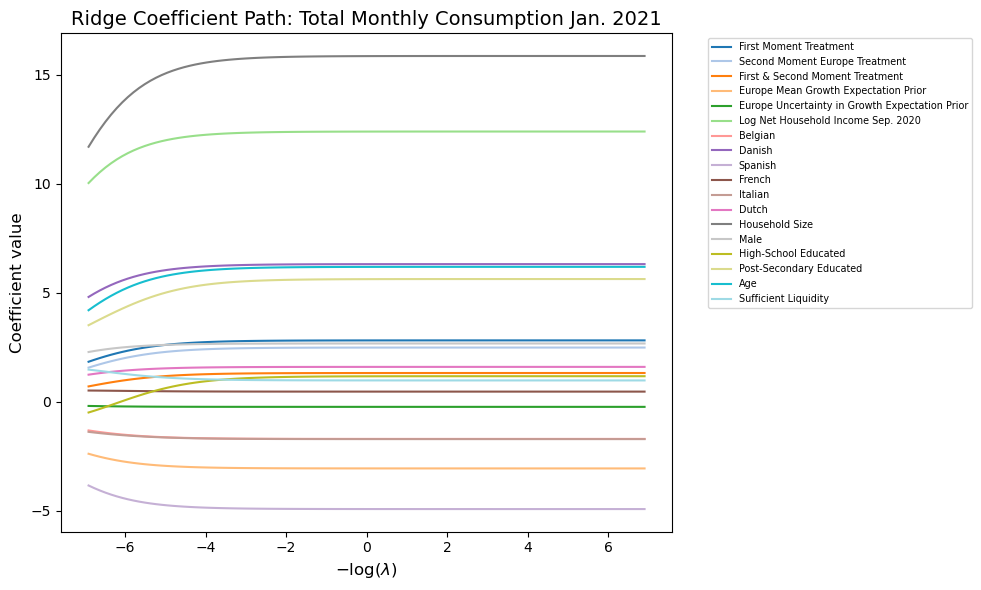

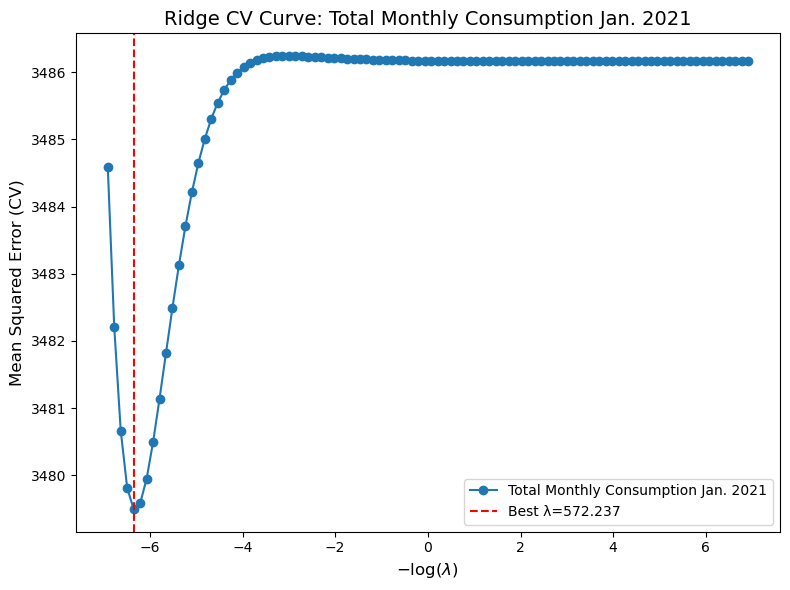

✅ Saved and displayed: ridge_wave13_coeff_path and ridge_wave13_cv_curve


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.cm as cm

# Load dataset
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert boolean to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Keep only rows with positive consumption
df = df[(df["Total Monthy Consumption Oct. 2020"] > 0) & 
        (df["Total Monthly Consumption Jan. 2021"] > 0)].dropna()

# Drop 'Second Moment Domestic Treatment' if exists
if "Second Moment Domestic Treatment" in df.columns:
    df = df.drop(columns=["Second Moment Domestic Treatment"])

# Filter out extreme consumption values
df_filtered = df[(df["Total Monthy Consumption Oct. 2020"] <= 10000) & 
                 (df["Total Monthly Consumption Jan. 2021"] <= 10000)]

# Define predictors
predictors = [col for col in df_filtered.columns if col not in [
    "Total Monthy Consumption Oct. 2020", 
    "Total Monthly Consumption Jan. 2021", 
    "Control Group"
]]

# Dependent variables
y1 = 100 * np.log(df_filtered["Total Monthy Consumption Oct. 2020"].astype(float))
y2 = 100 * np.log(df_filtered["Total Monthly Consumption Jan. 2021"].astype(float))

X_filtered = df_filtered[predictors].astype(float)

# Standardize predictors
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_filtered), columns=X_filtered.columns)

# Ridge settings
alphas = np.logspace(-3, 3, 100)

def ridge_path_and_cv(X, y, label, filename_prefix):
    # === Coefficient paths ===
    coefs = []
    for a in alphas:
        ridge = Ridge(alpha=a, max_iter=10000)
        ridge.fit(X, y)
        coefs.append(ridge.coef_)
    coefs = np.array(coefs)

    plt.figure(figsize=(10, 6))

    # Generate distinct colors
    n_vars = X.shape[1]
    colors = cm.tab20(np.linspace(0, 1, min(n_vars, 20)))

    for i, col in enumerate(X.columns):
        plt.plot(-np.log(alphas), coefs[:, i], 
                 label=col, color=colors[i % 20])  # cycle if >20 variables

    plt.xlabel(r"$-\log(\lambda)$", fontsize=12)
    plt.ylabel("Coefficient value", fontsize=12)
    plt.title(f"Ridge Coefficient Path: {label}", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="x-small")
    plt.tight_layout()
    plt.savefig(f"{filename_prefix}_coeff_path.pdf")
    plt.savefig(f"{filename_prefix}_coeff_path.png", dpi=300)
    plt.show()
    plt.close()

    # === Cross-validation curve (manual) ===
    mse_mean = []
    for a in alphas:
        ridge = Ridge(alpha=a)
        scores = cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_squared_error')
        mse_mean.append(-scores.mean())
    mse_mean = np.array(mse_mean)
    best_alpha = alphas[np.argmin(mse_mean)]

    plt.figure(figsize=(8, 6))
    plt.plot(-np.log(alphas), mse_mean, marker="o", label=f"{label}")
    plt.axvline(-np.log(best_alpha), linestyle="--", color="red", label=f"Best λ={best_alpha:.3f}")
    plt.xlabel(r"$-\log(\lambda)$", fontsize=12)
    plt.ylabel("Mean Squared Error (CV)", fontsize=12)
    plt.title(f"Ridge CV Curve: {label}", fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{filename_prefix}_cv_curve.pdf")
    plt.savefig(f"{filename_prefix}_cv_curve.png", dpi=300)
    plt.show()
    plt.close()

    print(f"✅ Saved and displayed: {filename_prefix}_coeff_path and {filename_prefix}_cv_curve")

# Run for both outcomes
ridge_path_and_cv(X_scaled, y1, "Total Monthy Consumption Oct. 2020", "ridge_wave10")
ridge_path_and_cv(X_scaled, y2, "Total Monthly Consumption Jan. 2021", "ridge_wave13")


C:\Users\Zach\AppData\Local\Temp\ipykernel_28124\4011426100.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


✅ Using only Second Moment Europe Treatment = 1
Test MSE: 1477917.98
Test RMSE: 1215.70
Test MAE: 880.50


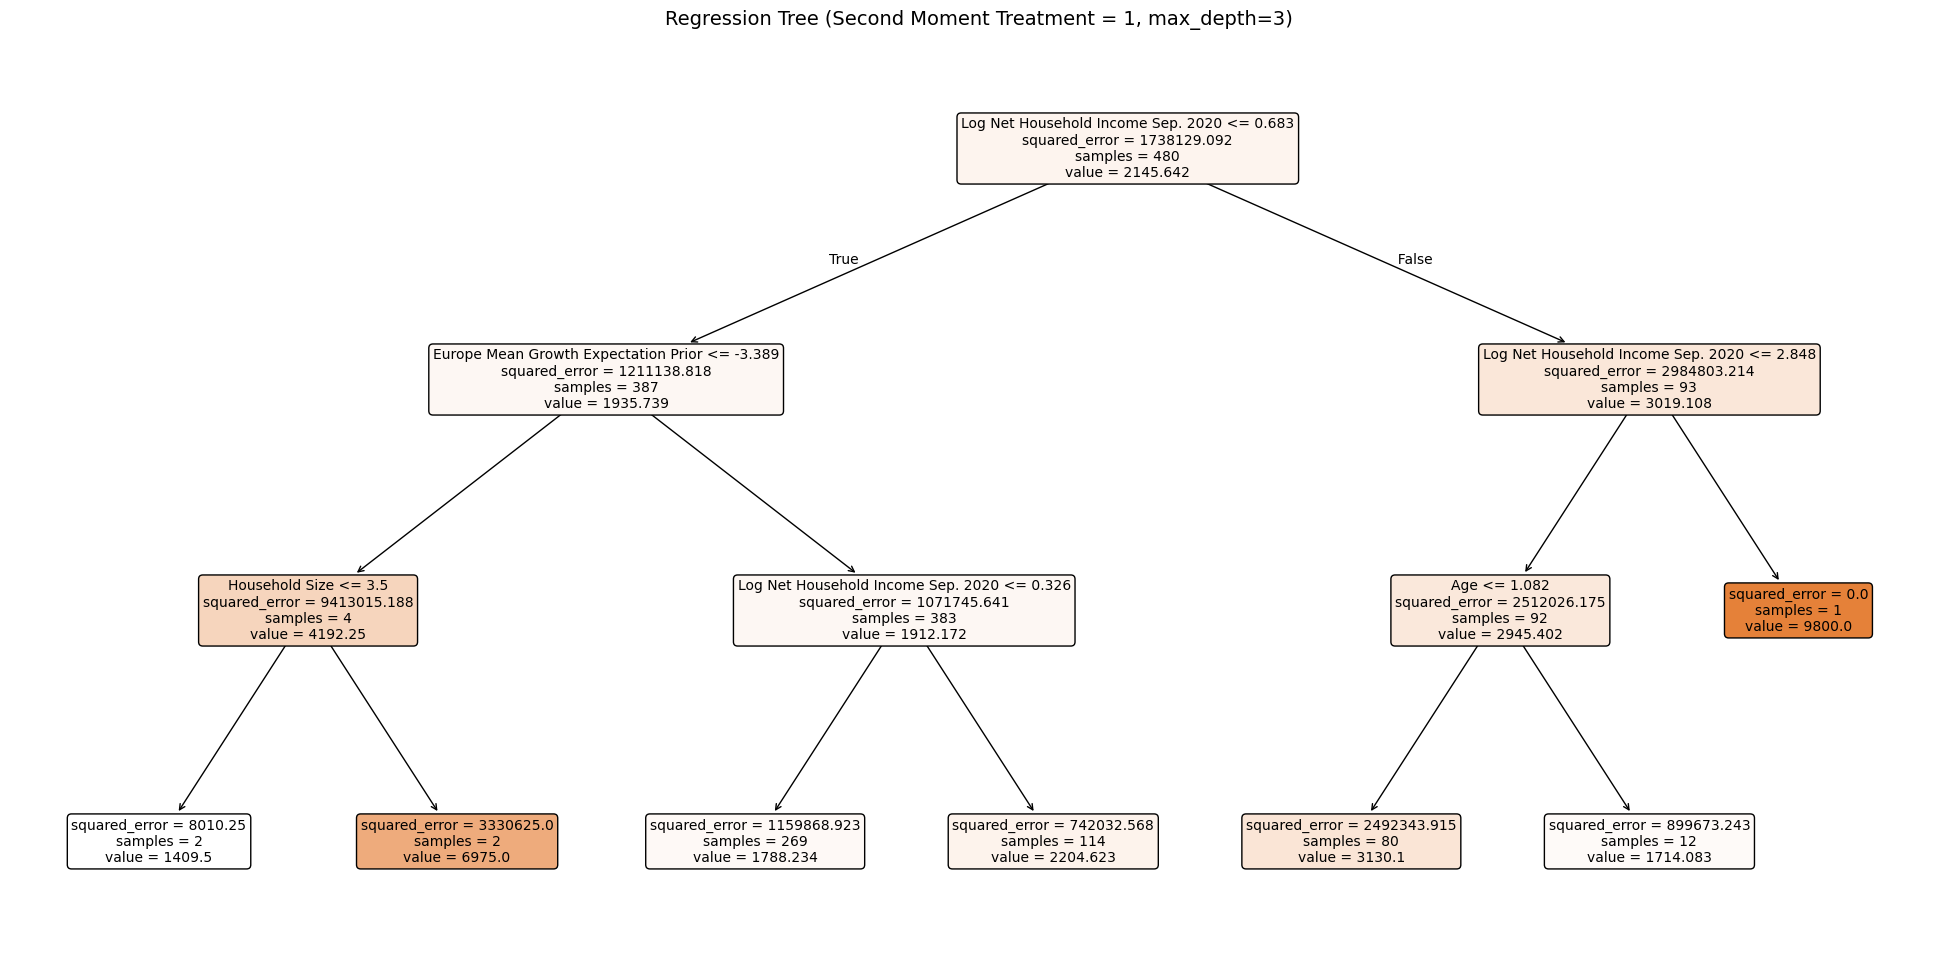

In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# --- Load and preprocess data ---
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert booleans to 0/1
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Force numeric
df = df.apply(pd.to_numeric, errors="coerce")

# --- Filter to Second Moment Treatment = 1 only ---
if "Second Moment Europe Treatment" not in df.columns:
    raise ValueError("⚠️ Column 'Second Moment Treatment' not found in dataset.")
df = df[df["Second Moment Europe Treatment"] == 1]

# Keep only positive consumption rows
df = df[df["Total Monthy Consumption Oct. 2020"] > 0].dropna()

# Drop 'Second Moment Domestic Treatment' if present
if "Second Moment Domestic Treatment" in df.columns:
    df = df.drop(columns=["Second Moment Domestic Treatment"])

# Filter out extreme values (>10,000)
df_filtered = df[df["Total Monthy Consumption Oct. 2020"] <= 10000]

# Define predictors (drop outcome, Control Group, and next wave consumption)
predictors = [col for col in df_filtered.columns if col not in [
    "Total Monthy Consumption Oct. 2020", 
    "Control Group", 
    "Total Monthly Consumption Jan. 2021"
]]
X = df_filtered[predictors].astype(float)
y = df_filtered["Total Monthy Consumption Oct. 2020"].astype(float)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Train regression tree with max depth 3 ---
tree_max3 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_max3.fit(X_train, y_train)

# --- Predictions and evaluation ---
y_pred = tree_max3.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"✅ Using only Second Moment Europe Treatment = 1")
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

# --- Plot the tree and save as PDF ---
plt.figure(figsize=(25, 12))
plot_tree(
    tree_max3,
    feature_names=list(X.columns),
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Regression Tree (Second Moment Treatment = 1, max_depth=3)", fontsize=14)

# Save PDF for LaTeX
plt.savefig("regression_tree_SMET1_max3.pdf", bbox_inches='tight')

# Display inline in Jupyter
plt.show()


In [ ]:
import pandas as pd

# Load your dataset (adjust path as needed)
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Define the variable of interest
var = "Total Monthly Consumption Oct. 2020"

# Compute thresholds for top and bottom 20%
top_20_cutoff = df[var].quantile(0.8)
bottom_20_cutoff = df[var].quantile(0.2)

# Create dummy variables
df["top20_dummy"] = (df[var] >= top_20_cutoff).astype(int)
df["bottom20_dummy"] = (df[var] <= bottom_20_cutoff).astype(int)

# Save the new dataset with the dummy variables
df.to_csv("CesDataClean3_subset_standardized4_with_dummies.csv", index=False)

# Optional: quick check
print(df[["top20_dummy", "bottom20_dummy"]].sum())


C:\Users\Zach\AppData\Local\Temp\ipykernel_48196\1984321839.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


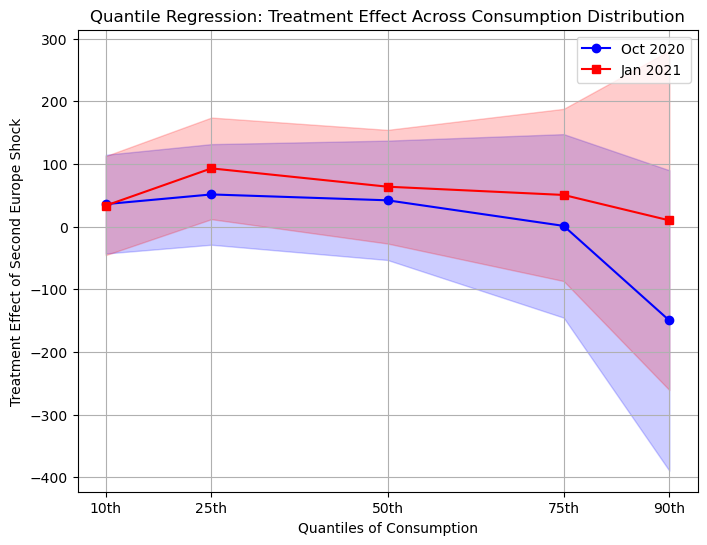

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- Load and prepare data ---
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert "true"/"false" strings to numeric 1/0
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Rename columns for clarity
df.rename(columns={
    "Total Monthy Consumption Oct. 2020": "TotalOct2020",
    "Total Monthly Consumption Jan. 2021": "TotalJan2021",
    "Second Moment Europe Treatment": "SecondEurope",
    "Log Net Household Income Sep. 2020": "LogIncome",
    "Household Size": "HouseholdSize",
    "Post-Secondary Educated": "PostSecondary",
    "Sufficient Liquidity": "Liquidity"
}, inplace=True)

# Keep valid positive consumption rows only
df = df[(df["TotalOct2020"] > 0) & (df["TotalJan2021"] > 0)].dropna()

# --- Controls ---
controls = ["HouseholdSize", "Male", "Age", "PostSecondary", "Liquidity"]

# --- Quantiles of interest ---
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

def quantile_treatment_effects(y_var, df, controls, quantiles):
    """Estimate treatment effect of SecondEurope across consumption quantiles."""
    betas, lower, upper = [], [], []
    X = df[["SecondEurope"] + controls]
    X = sm.add_constant(X)
    y = df[y_var]

    for q in quantiles:
        model = sm.QuantReg(y, X)
        res = model.fit(q=q)
        b = res.params["SecondEurope"]
        se = res.bse["SecondEurope"]  # asymptotic SE
        betas.append(b)
        z = 1.96  # 95% CI
        lower.append(b - z * se)
        upper.append(b + z * se)

    return np.array(betas), np.array(lower), np.array(upper)

# --- Run for Oct 2020 and Jan 2021 ---
beta_oct, lower_oct, upper_oct = quantile_treatment_effects("TotalOct2020", df, controls, quantiles)
beta_jan, lower_jan, upper_jan = quantile_treatment_effects("TotalJan2021", df, controls, quantiles)

# --- Plot ---
plt.figure(figsize=(8,6))

plt.plot(quantiles, beta_oct, '-o', color='blue', label="Oct 2020")
plt.fill_between(quantiles, lower_oct, upper_oct, color='blue', alpha=0.2)

plt.plot(quantiles, beta_jan, '-s', color='red', label="Jan 2021")
plt.fill_between(quantiles, lower_jan, upper_jan, color='red', alpha=0.2)

plt.xlabel("Quantiles of Consumption")
plt.xticks(quantiles, ['10th', '25th', '50th', '75th', '90th'])
plt.ylabel("Treatment Effect of Second Europe Shock")
plt.title("Quantile Regression: Treatment Effect Across Consumption Distribution")
plt.grid(True)
plt.legend()

plt.savefig("quantile_reg_treatment_effects.pdf", bbox_inches='tight')
plt.show()


C:\Users\Zach\AppData\Local\Temp\ipykernel_48196\2170410979.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  yerr=[[float(p90['effect'] - p90['ci_lower'])], [float(p90['ci_upper'] - p90['effect'])]],


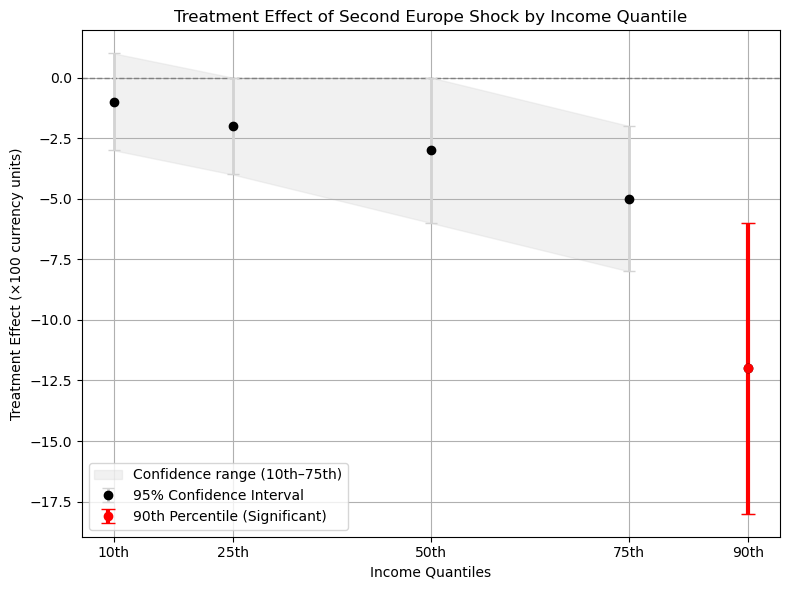

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data — replace with your actual regression output
data = pd.DataFrame({
    'quantile': [0.1, 0.25, 0.5, 0.75, 0.9],
    'effect': [-0.01, -0.02, -0.03, -0.05, -0.12],
    'ci_lower': [-0.03, -0.04, -0.06, -0.08, -0.18],
    'ci_upper': [0.01, 0.00, -0.00, -0.02, -0.06]
})

# --- Rescale by 100 ---
data[['effect', 'ci_lower', 'ci_upper']] *= 100

# Plot
plt.figure(figsize=(8,6))
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Plot all quantiles with 95% CI
plt.errorbar(
    data['quantile'],
    data['effect'],
    yerr=[data['effect'] - data['ci_lower'], data['ci_upper'] - data['effect']],
    fmt='o',
    color='black',
    ecolor='lightgray',
    elinewidth=2,
    capsize=4,
    label='95% Confidence Interval'
)

# Highlight the 90th percentile in red
p90 = data[data['quantile'] == 0.9]
plt.errorbar(
    p90['quantile'],
    p90['effect'],
    yerr=[[float(p90['effect'] - p90['ci_lower'])], [float(p90['ci_upper'] - p90['effect'])]],
    fmt='o',
    color='red',
    ecolor='red',
    elinewidth=3,
    capsize=5,
    label='90th Percentile (Significant)'
)

# Shade CI of 10th–75th quantiles
lower_band = data[data['quantile'] < 0.9]
plt.fill_between(
    lower_band['quantile'],
    lower_band['ci_lower'],
    lower_band['ci_upper'],
    color='lightgray',
    alpha=0.3,
    label='Confidence range (10th–75th)'
)

# Labels and formatting
plt.title('Treatment Effect of Second Europe Shock by Income Quantile')
plt.xlabel('Income Quantiles')
plt.xticks(data['quantile'], ['10th', '25th', '50th', '75th', '90th'])
plt.ylabel('Treatment Effect (×100 currency units)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\Zach\AppData\Local\Temp\ipykernel_48196\233764186.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))
C:\Users\Zach\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


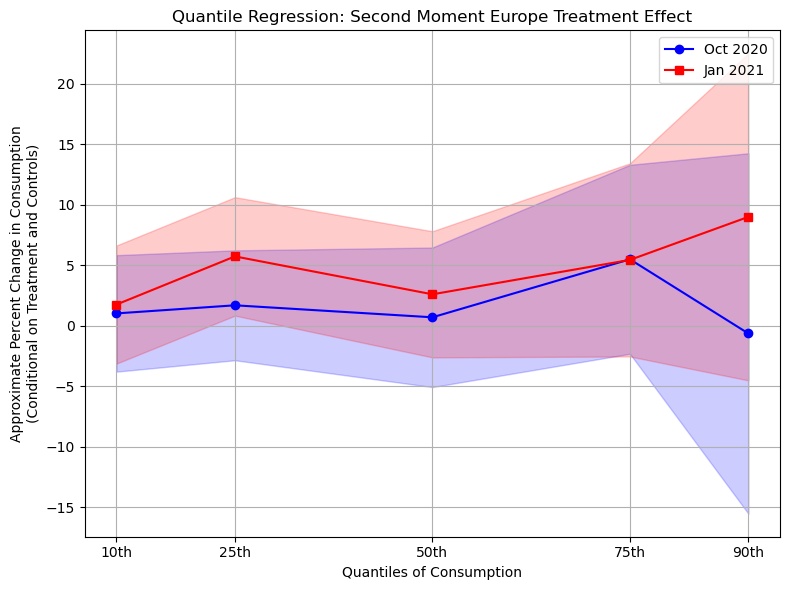

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- Load and prepare data ---
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert "true"/"false" strings to numeric 1/0
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Rename columns for clarity
df.rename(columns={
    "Total Monthy Consumption Oct. 2020": "TotalOct2020",
    "Total Monthly Consumption Jan. 2021": "TotalJan2021",
    "Second Moment Europe Treatment": "SecondEurope",
    "Log Net Household Income Sep. 2020": "LogIncome",
    "Household Size": "HouseholdSize",
    "Post-Secondary Educated": "PostSecondary",
    "Sufficient Liquidity": "Liquidity",
    "Control Group": "Control"
}, inplace=True)

# Keep only control group + SecondMoment Europe treatment
df = df[(df["SecondEurope"] == 1) | (df["Control"] == 1)]

# Keep valid positive consumption rows only
df = df[(df["TotalOct2020"] > 0) & (df["TotalJan2021"] > 0)].dropna()

# --- Controls ---
controls = ["HouseholdSize", "Male", "Age", "PostSecondary"]

# --- Quantiles of interest ---
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

# --- Function to estimate quantile treatment effects ---
def quantile_treatment_effects(y_var, df, controls, quantiles):
    """Estimate treatment effect of SecondEurope across consumption quantiles."""
    betas, lower, upper = [], [], []

    X = df[["SecondEurope"] + controls]
    X = sm.add_constant(X)
    y = df[y_var]

    for q in quantiles:
        model = sm.QuantReg(y, X)
        res = model.fit(q=q)
        b = res.params["SecondEurope"]
        se = res.bse["SecondEurope"]
        betas.append(b)
        z = 1.96  # 95% CI
        lower.append(b - z * se)
        upper.append(b + z * se)

    return np.array(betas), np.array(lower), np.array(upper)

# --- Run for Oct 2020 and Jan 2021 ---
beta_oct, lower_oct, upper_oct = quantile_treatment_effects("TotalOct2020", df, controls, quantiles)
beta_jan, lower_jan, upper_jan = quantile_treatment_effects("TotalJan2021", df, controls, quantiles)

# --- Convert to approximate percent change relative to mean consumption ---
mean_oct = df['TotalOct2020'].mean()
mean_jan = df['TotalJan2021'].mean()

beta_oct_pct = 100 * beta_oct / mean_oct
lower_oct_pct = 100 * lower_oct / mean_oct
upper_oct_pct = 100 * upper_oct / mean_oct

beta_jan_pct = 100 * beta_jan / mean_jan
lower_jan_pct = 100 * lower_jan / mean_jan
upper_jan_pct = 100 * upper_jan / mean_jan

# --- Plot ---
plt.figure(figsize=(8,6))

# Oct 2020
plt.plot(quantiles, beta_oct_pct, '-o', color='blue', label="Oct 2020")
plt.fill_between(quantiles, lower_oct_pct, upper_oct_pct, color='blue', alpha=0.2)

# Jan 2021
plt.plot(quantiles, beta_jan_pct, '-s', color='red', label="Jan 2021")
plt.fill_between(quantiles, lower_jan_pct, upper_jan_pct, color='red', alpha=0.2)

# Labels
plt.xlabel("Quantiles of Consumption")
plt.xticks(quantiles, ['10th', '25th', '50th', '75th', '90th'])
plt.ylabel("Approximate Percent Change in Consumption\n(Conditional on Treatment and Controls)")
plt.title("Quantile Regression: Second Moment Europe Treatment Effect")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig("quantile_reg_secondtreatment_effects_control_only_pct.pdf", bbox_inches='tight')
plt.show()


In [9]:
import pandas as pd

# --- Load dataset ---
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert "true"/"false" strings to numeric 1/0
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Rename columns for clarity
df.rename(columns={
    "Total Monthy Consumption Oct. 2020": "TotalOct2020",
    "Total Monthly Consumption Jan. 2021": "TotalJan2021",
    "Second Moment Europe Treatment": "SecondEurope",
    "Control Group": "Control"
}, inplace=True)

# Keep only positive consumption rows
df = df[(df["TotalOct2020"] > 0) & (df["TotalJan2021"] > 0)]

# --- Define quantiles ---
q_low, q_high = 0.1, 0.9

# Compute cutoffs based on entire sample
cutoffs = {}
for month in ["TotalOct2020", "TotalJan2021"]:
    cutoffs[month] = {
        "low": df[month].quantile(q_low),
        "high": df[month].quantile(q_high)
    }

# --- Function to count observations in percentiles ---
def count_percentiles(df, month, group_var, group_val):
    subset = df[df[group_var] == group_val]
    n_total = subset.shape[0]
    n_10th = (subset[month] <= cutoffs[month]["low"]).sum()
    n_90th = (subset[month] >= cutoffs[month]["high"]).sum()
    return n_total, n_10th, n_90th

# --- Prepare results table ---
results = []

for month in ["TotalOct2020", "TotalJan2021"]:
    for group_var, group_name in [("Control", "Control"), ("SecondEurope", "Treatment")]:
        total, n_10, n_90 = count_percentiles(df, month, group_var, 1)
        results.append({
            "Month": month,
            "Group": group_name,
            "Total": total,
            "10th Percentile": n_10,
            "90th Percentile": n_90
        })

# --- Convert to DataFrame and display ---
results_df = pd.DataFrame(results)
print(results_df)


          Month      Group  Total  10th Percentile  90th Percentile
0  TotalOct2020    Control    672               74               62
1  TotalOct2020  Treatment    685               58               61
2  TotalJan2021    Control    672               70               50
3  TotalJan2021  Treatment    685               63               75


C:\Users\Zach\AppData\Local\Temp\ipykernel_48196\3817067609.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


C:\Users\Zach\AppData\Local\Temp\ipykernel_48196\3561448717.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


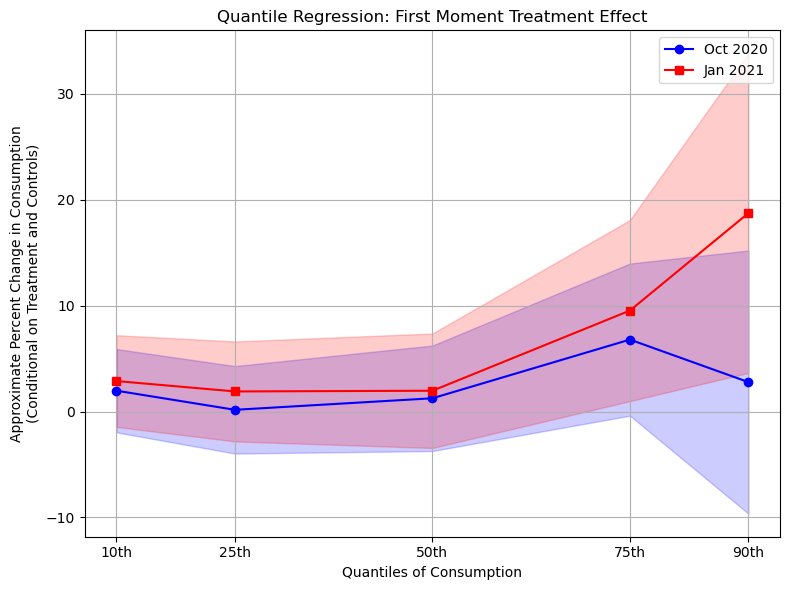

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- Load and prepare data ---
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert "true"/"false" strings to numeric 1/0
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Rename columns for clarity
df.rename(columns={
    "Total Monthy Consumption Oct. 2020": "TotalOct2020",
    "Total Monthly Consumption Jan. 2021": "TotalJan2021",
    "Second Moment Europe Treatment": "SecondEurope",
    "Log Net Household Income Sep. 2020": "LogIncome",
    "Household Size": "HouseholdSize",
    "Post-Secondary Educated": "PostSecondary",
    "Sufficient Liquidity": "Liquidity",
    "Control Group": "Control"
}, inplace=True)

# Keep only control group + SecondMoment Europe treatment
df = df[(df["First Moment Treatment"] == 1) | (df["Control"] == 1)]

# Keep valid positive consumption rows only
df = df[(df["TotalOct2020"] > 0) & (df["TotalJan2021"] > 0)].dropna()

# --- Controls ---
controls = ["HouseholdSize", "Male", "Age", "PostSecondary"]

# --- Quantiles of interest ---
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

# --- Function to estimate quantile treatment effects ---
def quantile_treatment_effects(y_var, df, controls, quantiles):
    """Estimate treatment effect of First Moment Treatment across consumption quantiles."""
    betas, lower, upper = [], [], []

    X = df[["First Moment Treatment"] + controls]
    X = sm.add_constant(X)
    y = df[y_var]

    for q in quantiles:
        model = sm.QuantReg(y, X)
        res = model.fit(q=q)
        b = res.params["First Moment Treatment"]
        se = res.bse["First Moment Treatment"]
        betas.append(b)
        z = 1.96  # 95% CI
        lower.append(b - z * se)
        upper.append(b + z * se)

    return np.array(betas), np.array(lower), np.array(upper)

# --- Run for Oct 2020 and Jan 2021 ---
beta_oct, lower_oct, upper_oct = quantile_treatment_effects("TotalOct2020", df, controls, quantiles)
beta_jan, lower_jan, upper_jan = quantile_treatment_effects("TotalJan2021", df, controls, quantiles)

# --- Convert to approximate percent change relative to mean consumption ---
mean_oct = df['TotalOct2020'].mean()
mean_jan = df['TotalJan2021'].mean()

beta_oct_pct = 100 * beta_oct / mean_oct
lower_oct_pct = 100 * lower_oct / mean_oct
upper_oct_pct = 100 * upper_oct / mean_oct

beta_jan_pct = 100 * beta_jan / mean_jan
lower_jan_pct = 100 * lower_jan / mean_jan
upper_jan_pct = 100 * upper_jan / mean_jan

# --- Plot ---
plt.figure(figsize=(8,6))

# Oct 2020
plt.plot(quantiles, beta_oct_pct, '-o', color='blue', label="Oct 2020")
plt.fill_between(quantiles, lower_oct_pct, upper_oct_pct, color='blue', alpha=0.2)

# Jan 2021
plt.plot(quantiles, beta_jan_pct, '-s', color='red', label="Jan 2021")
plt.fill_between(quantiles, lower_jan_pct, upper_jan_pct, color='red', alpha=0.2)

# Labels
plt.xlabel("Quantiles of Consumption")
plt.xticks(quantiles, ['10th', '25th', '50th', '75th', '90th'])
plt.ylabel("Approximate Percent Change in Consumption\n(Conditional on Treatment and Controls)")
plt.title("Quantile Regression: First Moment Treatment Effect")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig("quantile_reg_firsttreatment_effects_control_only_pct.pdf", bbox_inches='tight')
plt.show()


C:\Users\Zach\AppData\Local\Temp\ipykernel_48196\3498248411.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))


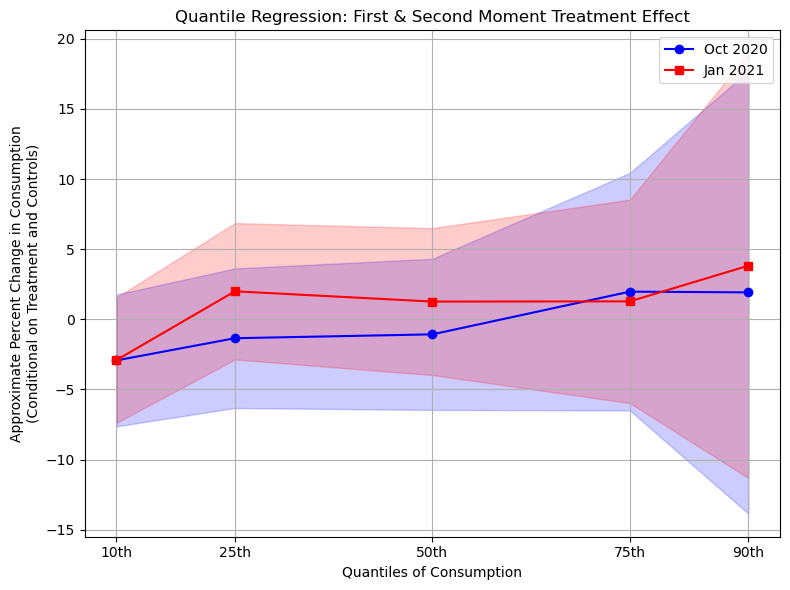

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- Load and prepare data ---
df = pd.read_csv("CesDataClean3_subset_standardized4.csv")

# Convert "true"/"false" strings to numeric 1/0
df = df.applymap(lambda x: 1 if str(x).lower() == "true" else (0 if str(x).lower() == "false" else x))

# Rename columns for clarity
df.rename(columns={
    "Total Monthy Consumption Oct. 2020": "TotalOct2020",
    "Total Monthly Consumption Jan. 2021": "TotalJan2021",
    "Second Moment Europe Treatment": "SecondEurope",
    "Log Net Household Income Sep. 2020": "LogIncome",
    "Household Size": "HouseholdSize",
    "Post-Secondary Educated": "PostSecondary",
    "Sufficient Liquidity": "Liquidity",
    "Control Group": "Control"
}, inplace=True)

# Keep only control group + SecondMoment Europe treatment
df = df[(df["First & Second Moment Treatment"] == 1) | (df["Control"] == 1)]

# Keep valid positive consumption rows only
df = df[(df["TotalOct2020"] > 0) & (df["TotalJan2021"] > 0)].dropna()

# --- Controls ---
controls = ["HouseholdSize", "Male", "Age", "PostSecondary"]

# --- Quantiles of interest ---
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

# --- Function to estimate quantile treatment effects ---
def quantile_treatment_effects(y_var, df, controls, quantiles):
    """Estimate treatment effect of First & Second Moment Treatment across consumption quantiles."""
    betas, lower, upper = [], [], []

    X = df[["First & Second Moment Treatment"] + controls]
    X = sm.add_constant(X)
    y = df[y_var]

    for q in quantiles:
        model = sm.QuantReg(y, X)
        res = model.fit(q=q)
        b = res.params["First & Second Moment Treatment"]
        se = res.bse["First & Second Moment Treatment"]
        betas.append(b)
        z = 1.96  # 95% CI
        lower.append(b - z * se)
        upper.append(b + z * se)

    return np.array(betas), np.array(lower), np.array(upper)

# --- Run for Oct 2020 and Jan 2021 ---
beta_oct, lower_oct, upper_oct = quantile_treatment_effects("TotalOct2020", df, controls, quantiles)
beta_jan, lower_jan, upper_jan = quantile_treatment_effects("TotalJan2021", df, controls, quantiles)

# --- Convert to approximate percent change relative to mean consumption ---
mean_oct = df['TotalOct2020'].mean()
mean_jan = df['TotalJan2021'].mean()

beta_oct_pct = 100 * beta_oct / mean_oct
lower_oct_pct = 100 * lower_oct / mean_oct
upper_oct_pct = 100 * upper_oct / mean_oct

beta_jan_pct = 100 * beta_jan / mean_jan
lower_jan_pct = 100 * lower_jan / mean_jan
upper_jan_pct = 100 * upper_jan / mean_jan

# --- Plot ---
plt.figure(figsize=(8,6))

# Oct 2020
plt.plot(quantiles, beta_oct_pct, '-o', color='blue', label="Oct 2020")
plt.fill_between(quantiles, lower_oct_pct, upper_oct_pct, color='blue', alpha=0.2)

# Jan 2021
plt.plot(quantiles, beta_jan_pct, '-s', color='red', label="Jan 2021")
plt.fill_between(quantiles, lower_jan_pct, upper_jan_pct, color='red', alpha=0.2)

# Labels
plt.xlabel("Quantiles of Consumption")
plt.xticks(quantiles, ['10th', '25th', '50th', '75th', '90th'])
plt.ylabel("Approximate Percent Change in Consumption\n(Conditional on Treatment and Controls)")
plt.title("Quantile Regression: First & Second Moment Treatment Effect")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig("quantile_reg_firstandsecondtreatment_effects_control_only_pct.pdf", bbox_inches='tight')
plt.show()
